### 1. Imports

#### 1.1 Overview

This section is where the required libraries and modules are imported

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# import torch
from sklearn.linear_model import LinearRegression as LR
from sklearn.tree import DecisionTreeRegressor as DT
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.svm import SVR

### 2. Data reading and preview

#### 2.1 Overview

This section involves loading and checking the data ahead of modeling

In [2]:
catalonia_analysis_df = pd.read_parquet("../datasets/processed/catalonia_analysis_df.parquet", engine='fastparquet')

In [ ]:
catalonia_analysis_df.head() 

,metres_cadastre,energia_primaria_no_renovable,rehabilitacio_energetica,emissions_co2,consum_energia_final,cost_anual_energia_habitatge,any_construccio_lri,valor_aïllaments,valor_finestres,valor_finestres_cte,...,emissions_calefaccio,emissions_refrigeracio,emissions_acs,emissions_enllumenament,latitud,longitud,poblacio,comarca,nom_provincia,cost_m2
index,,,,,,,,,,,,,,,,,,,,,
0,55.0,261.50,NO,50.33,180.63,16.90,1978.053589,0.73,3.78,2.1,...,30.160000,0.91,19.27,0.00,41.443798,2.138852,Escala (L'),Alt Empordà,Girona,0.307273
1,116.0,289.13,NO,75.53,242.61,18.39,1993.678101,2.94,5.00,2.1,...,69.160004,1.32,5.05,0.00,41.443798,2.138852,Vilamacolum,Alt Empordà,Girona,0.158534
2,122.0,260.98,NO,44.21,133.56,21.18,1979.498291,1.19,3.66,2.1,...,35.500000,3.96,4.74,0.00,41.443798,2.138852,Alforja,Baix Camp,Tarragona,0.173607
3,104.0,28.12,NO,4.76,14.39,2.28,2005.651367,0.43,2.88,2.1,...,2.540000,1.13,1.11,0.00,41.443798,2.138852,Alforja,Baix Camp,Tarragona,0.021923
4,1730.0,24.76,NO,4.24,61.51,8.77,1986.248291,0.30,2.04,2.1,...,0.290000,0.78,2.96,2.21,41.443798,2.138852,Vilamalla,Alt Empordà,Girona,0.005069


In [4]:
catalonia_analysis_df.isnull().mean().sum()

np.float64(0.0)

In [5]:
def optimize_dataframe_memory(df):
    df = df.copy()
    print(f"Original memory usage: {df.memory_usage().sum() / 1024 ** 2:.2f} MB")
    
    # Downcasting integers
    int_cols = df.select_dtypes(include=['int64', 'int32']).columns
    df[int_cols] = df[int_cols].apply(pd.to_numeric, downcast='integer')
    
    # Downcasting floats
    float_cols = df.select_dtypes(include=['float64']).columns
    df[float_cols] = df[float_cols].apply(pd.to_numeric, downcast='float')
    
    # Converting object columns to category if there are fewer unique values than 50% of total rows
    object_cols = df.select_dtypes(include=['object']).columns
    for col in object_cols:
        num_unique_values = df[col].nunique()
        num_total_values = len(df[col])
        if num_unique_values / num_total_values < 0.5:
            df[col] = df[col].astype('category')
    
    print(f"Optimized memory usage: {df.memory_usage().sum() / 1024 ** 2:.2f} MB")
    return df

def display_dataframe_info(df):
    # Print the shape of the dataframe
    print('Shape:', df.shape)
    
    # Print the column names with their data types
    dtypes_list = [f"{col}:{dtype}" for col, dtype in zip(df.columns, df.dtypes)]
    print('Dtypes:', dtypes_list)
    
    # Print the column names with the percentage of missing values
    missings_list = [f"{col}:{missing:.2f}%" for col, missing in zip(df.columns, df.isnull().mean()*100)]
    print('Missings (%):', missings_list)
    
    # Calculate total missing percentage
    total_missing_percentage = (df.isnull().sum().sum() / df.size) * 100
    print(f'Total missings (%): {total_missing_percentage:.2f}%')

    
    # Print total duplicates
    print('total duplicates:', df.duplicated(keep=False).sum())
    
    # Print the total memory consumed by the dataframe
    memory_usage = df.memory_usage().sum() / 1024**2  # Convert bytes to megabytes (MB)
    print(f"Total memory usage: {memory_usage:.2f} MB")
    
    # Display the first 2 rows of the dataframe
    return df.head(2)



### 3. Modeling

#### 3.1 Overview

Modeling Question:

Develop ONE of the following machine learning models (you may integrate additional datasets to improve performance):
- A model that estimates a building’s energy efficiency class.
- 🔹**A model that predicts a building’s energy consumption (kWh/m²)**
- A model that provides tailored renovation recommendations based on building characteristics.
- A model that estimates the cost of renovations needed to upgrade a building from one energy efficiency class to another.

My Choice:  **A model that predicts a building’s energy consumption (kWh/m²)**

Steps to develop a model that predicts a building's energy consumption (kWh/m²):

**1. Define the Problem and Target Variable**
- Target variable: `"consum_energia_final"` (energy consumption in kWh/m²).
- Features: Building characteristics, insulation, heating systems, and other relevant attributes.

**2. Data Preparation**
- Handle missing values using imputation (e.g., median for numerical features).
- Encode categorical variables (e.g., `us_edifici`, `tipus_tramit`, `normativa_construccio`).
- Scale numerical variables for better model performance.

**3. Feature Selection**
- Potential features:
  - **Building characteristics:** `metres_cadastre`, `any_construccio_lri`, `normativa_construccio`, `us_edifici`
  - **Energy-related attributes:** `energia_primaria_no_renovable`, `solar_termica`, `solar_fotovoltaica`, `sistema_biomassa`
  - **Insulation quality:** `valor_aïllaments`, `valor_finestres`, `valor_finestres_cte`
  - **Heating and emissions:** `qualificacio_energia_calefaccio`, `qualificacio_energia_refrigeracio`, `emissions_co2`

**4. Model Selection**
- Start with baseline models:
  - Linear Regression (simple baseline)
  - Random Forest Regressor
  - Gradient Boosting (e.g., XGBoost, LightGBM)
- Evaluate with metrics like MAE, RMSE, and R².

**5. Model Training & Evaluation**
- Split the data into training and test sets.
- Train the model using cross-validation.
- Tune hyperparameters (e.g., using GridSearchCV).

**6. Interpretation & Deployment**
- Feature importance analysis (SHAP values, permutation importance).
- Predict energy consumption for new/unseen buildings.
- Integrate with renovation cost analysis.


In [6]:
display_dataframe_info(catalonia_analysis_df)

Shape: (1323791, 34)
Dtypes: ['metres_cadastre:float64', 'energia_primaria_no_renovable:float64', 'rehabilitacio_energetica:category', 'emissions_co2:float64', 'consum_energia_final:float64', 'cost_anual_energia_habitatge:float64', 'any_construccio_lri:float32', 'valor_aïllaments:float32', 'valor_finestres:float64', 'valor_finestres_cte:float32', 'qualificacio_energia_calefaccio:category', 'qualificacio_energia_refrigeracio:category', 'qualificacio_energia_acs:category', 'actuacions_rehabilitacio_ml:category', 'any_construccio_mbi:float32', 'solar_termica:category', 'solar_fotovoltaica:category', 'sistema_biomassa:category', 'energia_geotermica:category', 'tipus_tramit:category', 'normativa_construccio:category', 'us_edifici:category', 'energia_acs:float64', 'energia_enllumenament:float32', 'emissions_calefaccio:float32', 'emissions_refrigeracio:float32', 'emissions_acs:float32', 'emissions_enllumenament:float32', 'latitud:float32', 'longitud:float32', 'poblacio:category', 'comarca:cat

,metres_cadastre,energia_primaria_no_renovable,rehabilitacio_energetica,emissions_co2,consum_energia_final,cost_anual_energia_habitatge,any_construccio_lri,valor_aïllaments,valor_finestres,valor_finestres_cte,...,emissions_calefaccio,emissions_refrigeracio,emissions_acs,emissions_enllumenament,latitud,longitud,poblacio,comarca,nom_provincia,cost_m2
index,,,,,,,,,,,,,,,,,,,,,
0,55.0,261.50,NO,50.33,180.63,16.90,1978.053589,0.73,3.78,2.1,...,30.160000,0.91,19.27,0.0,41.443798,2.138852,Escala (L'),Alt Empordà,Girona,0.307273
1,116.0,289.13,NO,75.53,242.61,18.39,1993.678101,2.94,5.00,2.1,...,69.160004,1.32,5.05,0.0,41.443798,2.138852,Vilamacolum,Alt Empordà,Girona,0.158534


In [7]:
numeric_cols = catalonia_analysis_df.select_dtypes(include='number').columns
cat_cols = catalonia_analysis_df.select_dtypes(exclude='number').columns

print('num_cols:', numeric_cols.to_list())
print('cat_cols:', cat_cols.to_list())

num_cols: ['metres_cadastre', 'energia_primaria_no_renovable', 'emissions_co2', 'consum_energia_final', 'cost_anual_energia_habitatge', 'any_construccio_lri', 'valor_aïllaments', 'valor_finestres', 'valor_finestres_cte', 'any_construccio_mbi', 'energia_acs', 'energia_enllumenament', 'emissions_calefaccio', 'emissions_refrigeracio', 'emissions_acs', 'emissions_enllumenament', 'latitud', 'longitud', 'cost_m2']
cat_cols: ['rehabilitacio_energetica', 'qualificacio_energia_calefaccio', 'qualificacio_energia_refrigeracio', 'qualificacio_energia_acs', 'actuacions_rehabilitacio_ml', 'solar_termica', 'solar_fotovoltaica', 'sistema_biomassa', 'energia_geotermica', 'tipus_tramit', 'normativa_construccio', 'us_edifici', 'poblacio', 'comarca', 'nom_provincia']


In [8]:
# import os
# import joblib
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from tqdm import tqdm
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestRegressor
# from xgboost import XGBRegressor
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# def train_energy_consumption_models(df, target, features, save_path="models/"):
#     """
#     Train multiple models to predict energy consumption (kWh/m²).
    
#     Args:
#         df (pd.DataFrame): Cleaned dataset.
#         target (str): Name of the target variable.
#         features (list): List of feature column names.
#         save_path (str): Directory path to save trained models.
    
#     Returns:
#         results_df (pd.DataFrame): Model performance metrics.
#         trained_models (dict): Dictionary of trained models.
#         feature_importances (dict): Feature importance per model.
#     """

#     # 🔹 Ensure the save path exists
#     os.makedirs(save_path, exist_ok=True)

#     # 🔹 Split data
#     X = df[features]
#     y = df[target]

#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#     # 🔹 Initialize models
#     models = {
#         "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
#         "XGBoost": XGBRegressor(n_estimators=100, random_state=42, objective="reg:squarederror"),
#     }

#     results = {}
#     trained_models = {}
#     feature_importances = {}

#     for name, model in tqdm(models.items(), desc="Training Models"):
#         print(f"\n🔹 Training {name}...")

#         # 🔹 Train the model
#         model.fit(X_train, y_train)

#         # 🔹 Make predictions
#         y_pred = model.predict(X_test)

#         # 🔹 Compute Metrics
#         mae = mean_absolute_error(y_test, y_pred)
#         rmse = mean_squared_error(y_test, y_pred)  # Root Mean Squared Error
#         r2 = r2_score(y_test, y_pred)

#         results[name] = {"MAE": mae, "RMSE": rmse, "R²": r2}
#         trained_models[name] = model  # Store trained model

#         # 🔹 Save trained model checkpoint
#         model_path = os.path.join(save_path, f"{name.replace(' ', '_')}.pkl")
#         joblib.dump(model, model_path)

#         # 🔹 Extract feature importances if applicable
#         if hasattr(model, "feature_importances_"):
#             importance_df = pd.DataFrame(
#                 {"Feature": features, "Importance": model.feature_importances_}
#             ).sort_values(by="Importance", ascending=False).head(10)
#             feature_importances[name] = importance_df

#             # 🔹 Plot feature importance
#             plt.figure(figsize=(8, 5))
#             sns.barplot(x=importance_df["Importance"], y=importance_df["Feature"], palette="viridis")
#             plt.title(f"🔹 {name} - Top 10 Feature Importances")
#             plt.xlabel("Importance Score")
#             plt.ylabel("Feature")
#             plt.show()

#     # 🔹 Convert results to DataFrame
#     results_df = pd.DataFrame(results).T
#     print("\n🔹 Model Performance Comparison:")
#     print(results_df)

#     return results_df, trained_models, feature_importances


In [97]:


# 🔹 Use MPS (Metal Performance Shaders) if available for acceleration
# device = "mps" if torch.backends.mps.is_available() else "cpu"
# print(f"🔹 Using device: {device.upper()}")


# def train_energy_consumption_models(df, models, target, num_cols, cat_cols, save_path="models/"):
#     """
#     Train multiple models to predict energy consumption (kWh/m²), using MinMax scaling, optimized encoding, 
#     and parallel processing.

#     Args:
#         df (pd.DataFrame): Cleaned dataset.
#         models (dict): Dictionary of model instances.
#         target (str): Name of the target variable.
#         num_cols (list): List of numerical feature column names.
#         cat_cols (list): List of categorical feature column names.
#         save_path (str): Directory path to save trained models.

#     Returns:
#         results_df (pd.DataFrame): Model performance metrics.
#         trained_models (dict): Dictionary of trained models.
#         feature_importances (dict): Feature importance per model.
#         label_encoders (dict): Dictionary of label encoders for categorical features.
#         scaler (MinMaxScaler): Trained MinMaxScaler for later use.
#     """

#     num_cols = [col for col in num_cols if col != target]
#     cat_cols = [col for col in cat_cols if col != target]

#     # 🔹 Ensure save directory exists
#     os.makedirs(save_path, exist_ok=True)

#     # 🔹 Encode categorical variables
#     label_encoders = {}
#     print("\n🔹 Encoding categorical variables...")
#     for col in tqdm(cat_cols, desc="Encoding Progress"):
#         le = LabelEncoder()
#         df[col] = le.fit_transform(df[col])
#         label_encoders[col] = le  # Store encoders for later use

#     # 🔹 Apply MinMax Scaling to numerical features
#     print("\n🔹 Scaling numerical features...")
#     scaler = MinMaxScaler()
#     df[num_cols] = scaler.fit_transform(df[num_cols])

#     # 🔹 Select features
#     features = num_cols + cat_cols
#     X = df[features].values  # Convert to NumPy array for efficiency
#     y = df[target].values

#     # 🔹 Split data
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

#     results = {}
#     trained_models = {}
#     feature_importances = {}

#     for name, model in tqdm(models.items(), desc="Training Models"):
#         print(f"\n🔹 Training {name}...")

#         # 🔹 Train the model
#         model.fit(X_train, y_train)

#         # 🔹 Make predictions
#         y_pred = model.predict(X_test)

#         # 🔹 Compute Metrics
#         mae = mean_absolute_error(y_test, y_pred)
#         rmse = mean_squared_error(y_test, y_pred)  # RMSE
#         r2 = r2_score(y_test, y_pred)

#         results[name] = {"MAE": mae, "RMSE": rmse, "R²": r2}
#         trained_models[name] = model  # Store trained model

#         # 🔹 Save trained model checkpoint
#         model_path = os.path.join(save_path, f"{name.replace(' ', '_')}.pkl")
#         joblib.dump(model, model_path)

#         # 🔹 Extract feature importances if applicable
#         if hasattr(model, "feature_importances_"):
#             importance_df = pd.DataFrame(
#                 {"Feature": features, "Importance": model.feature_importances_}
#             ).sort_values(by="Importance", ascending=False).head(10)
#             feature_importances[name] = importance_df

#             # 🔹 Plot feature importance
#             plt.figure(figsize=(14, 5))
#             sns.barplot(x=importance_df["Importance"], y=importance_df["Feature"], palette="viridis", hue=importance_df["Feature"], legend=False)
#             plt.title(f"🔹 {name} - Top 10 Feature Importances")
#             plt.xlabel("Importance Score")
#             plt.ylabel("Feature")
#             plt.show()

#     # 🔹 Convert results to DataFrame
#     results_df = pd.DataFrame(results).T
#     print("\n🔹 Model Performance Comparison:")
#     print(results_df)

#     return results_df, trained_models, feature_importances, label_encoders, scaler

import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor,
    StackingRegressor, VotingRegressor
)
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import xgboost
import shap
import lime
import lime.lime_tabular
import IPython.display as display

def explain_model_with_shap_lime(model, X_train, X_test, sample_idx=0, num_features=10):
    """
    Explain a trained model using SHAP (global + local explanations) and LIME (local explanations),
    with interactive visualizations.

    Args:
        model (object): Trained model (e.g., XGBoost, LightGBM, RandomForest, etc.).
        X_train (pd.DataFrame or np.array): Training data (used for SHAP explainer).
        X_test (pd.DataFrame or np.array): Test data (used for generating explanations).
        sample_idx (int): Index of the test sample to explain using LIME.
        num_features (int): Number of top features to visualize.

    Returns:
        dict: Dictionary containing SHAP and LIME explanations.
    """

    print("\n🔹 Generating SHAP explanations...\n")
    
    # SHAP Explainer (Tree-based models vs others)
    if hasattr(model, "predict_proba") or hasattr(model, "feature_importances_"):
        explainer = shap.TreeExplainer(model)
    else:
        explainer = shap.Explainer(model, X_train)

    shap_values = explainer(X_test)

    ## ✅ SHAP Global Feature Importance (Static Plot)
    shap.summary_plot(shap_values, X_test, show=False)
    plt.title("SHAP Feature Importance (Global)")
    plt.show()

    ## ✅ SHAP Local Explanation (Interactive Force Plot)
    print(f"\n🔹 SHAP Explanation for Test Sample {sample_idx}\n")
    shap.initjs()  # Enables interactive visualizations
    display.display(shap.force_plot(explainer.expected_value, shap_values[sample_idx].values, X_test.iloc[sample_idx]))

    print("\n🔹 Generating LIME explanation...\n")

    ## ✅ LIME Explainer
    lime_explainer = lime.lime_tabular.LimeTabularExplainer(
        X_train.values if hasattr(X_train, 'values') else X_train, 
        feature_names=X_train.columns if hasattr(X_train, 'columns') else [f"Feature {i}" for i in range(X_train.shape[1])], 
        class_names=["Target"], 
        mode="regression" if hasattr(model, "predict") and not hasattr(model, "predict_proba") else "classification"
    )

    ## ✅ LIME Local Explanation (Interactive HTML)
    exp = lime_explainer.explain_instance(X_test.iloc[sample_idx].values, model.predict, num_features=num_features)
    html_exp = exp.as_html()
    display.display(display.HTML(html_exp))  # Render in a Jupyter Notebook

    return {
        "shap_values": shap_values,
        "lime_explanation": exp
    }


# def train_energy_consumption_models(df, models, target, num_cols, cat_cols, save_path="models/"):
#     """
#     Train multiple models to predict energy consumption (kWh/m²), using optimized encoding and parallel processing.

#     Args:
#         df (pd.DataFrame): Cleaned dataset.
#         models (dict): Dictionary of models to train.
#         target (str): Name of the target variable.
#         num_cols (list): List of numerical feature column names.
#         cat_cols (list): List of categorical feature column names.
#         save_path (str): Directory path to save trained models.

#     Returns:
#         results_df (pd.DataFrame): Model performance metrics.
#         trained_models (dict): Dictionary of trained models.
#         feature_importances (dict): Feature importance per model.
#         label_encoders (dict): Dictionary of label encoders for categorical features.
#         scaler (MinMaxScaler): Scaler used for transformation (for future use).
#     """

#     # 🔹 Ensure target is not included in feature lists
#     num_cols = [col for col in num_cols if col != target]
#     cat_cols = [col for col in cat_cols if col != target]

#     # 🔹 Ensure save path exists
#     os.makedirs(save_path, exist_ok=True)

#     # 🔹 Encode categorical variables
#     label_encoders = {}
#     print("\n🔹 Encoding categorical variables...")
#     for col in tqdm(cat_cols, desc="Encoding Progress"):
#         le = LabelEncoder()
#         df[col] = le.fit_transform(df[col])
#         label_encoders[col] = le  # Store encoders for later use

#     # 🔹 Select features
#     features = num_cols + cat_cols
#     X = df[features].values  # Convert to NumPy array for efficiency
#     y = df[target].values.reshape(-1, 1)  # Ensure target is in 2D shape for scaling

#     # 🔹 Apply MinMaxScaler
#     scaler = MinMaxScaler()
#     X_scaled = scaler.fit_transform(X)
#     y_scaled = scaler.fit_transform(y)  # Scale target variable

#     # 🔹 Split data
#     X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=7)

#     results = {}
#     trained_models = {}
#     feature_importances = {}

#     for name, model in tqdm(models.items(), desc="Training Models"):
#         print(f"\n🔹 Training {name}...")

#         # 🔹 Train the model
#         model.fit(X_train, y_train.ravel())  # Flatten y_train to avoid DataConversionWarning

#         # 🔹 Make predictions (scaled)
#         y_pred_scaled = model.predict(X_test)

#         # 🔹 Reverse scaling to get actual kWh/m²
#         y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
#         y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

#         # 🔹 Compute Metrics in Original Units
#         mae = mean_absolute_error(y_test_original, y_pred)
#         rmse = root_mean_squared_error(y_test_original, y_pred)  # RMSE
#         r2 = r2_score(y_test_original, y_pred)

#         results[name] = {"MAE (kWh/m²)": mae, "RMSE (kWh/m²)": rmse, "R²": r2}
#         trained_models[name] = model  # Store trained model

#         # 🔹 Save trained model checkpoint
#         model_path = os.path.join(save_path, f"{name.replace(' ', '_')}.pkl")
#         joblib.dump(model, model_path)

#         # 🔹 Extract feature importances if applicable
#         if hasattr(model, "feature_importances_"):
#             importance_df = pd.DataFrame(
#                 {"Feature": features, "Importance": model.feature_importances_}
#             ).sort_values(by="Importance", ascending=False).head(10)
#             feature_importances[name] = importance_df

#             # 🔹 Plot feature importance
#             plt.figure(figsize=(14, 5))
#             sns.barplot(x=importance_df["Importance"], y=importance_df["Feature"], palette="viridis", hue=importance_df["Feature"], legend=False)
#             plt.title(f"🔹 {name} - Top 10 Feature Importances")
#             plt.xlabel("Importance Score")
#             plt.ylabel("Feature")
#             plt.show()

#     # 🔹 Convert results to DataFrame
#     results_df = pd.DataFrame(results).T
#     print("\n🔹 Model Performance Comparison:")
#     print(results_df)

#     return results_df, trained_models, feature_importances, label_encoders, scaler  # Return scaler for later use

# def train_energy_consumption_models(
#     df, models, target, num_cols, cat_cols, save_path="models/",
#     scale=True, shuffle=True, stratify=False, test_size=0.2
# ):
#     """
#     Train multiple models to predict energy consumption (kWh/m²) with optional scaling, shuffling, and stratification.

#     Args:
#         df (pd.DataFrame): Cleaned dataset.
#         models (dict): Dictionary of models to train.
#         target (str): Name of the target variable.
#         num_cols (list): List of numerical feature column names.
#         cat_cols (list): List of categorical feature column names.
#         save_path (str): Directory path to save trained models.
#         scale (bool): Whether to apply MinMax scaling to features and target.
#         shuffle (bool): Whether to shuffle the dataset before splitting.
#         stratify (bool): Whether to stratify the dataset based on the target variable.

#     Returns:
#         results_df (pd.DataFrame): Model performance metrics.
#         trained_models (dict): Dictionary of trained models.
#         feature_importances (dict): Feature importance per model.
#         label_encoders (dict): Dictionary of label encoders for categorical features.
#         x_scaler (MinMaxScaler or None): Scaler used for feature transformation (if applied).
#         y_scaler (MinMaxScaler or None): Scaler used for target transformation (if applied).
#     """
#     # 🔹 Ensure target is not included in feature lists
#     num_cols = [col for col in num_cols if col != target]
#     cat_cols = [col for col in cat_cols if col != target]
    
#     # 🔹 Ensure save path exists
#     os.makedirs(save_path, exist_ok=True)
    
#     # 🔹 Encode categorical variables
#     label_encoders = {}
#     print("\n🔹 Encoding categorical variables...")
#     for col in tqdm(cat_cols, desc="Encoding Progress"):
#         le = LabelEncoder()
#         df[col] = le.fit_transform(df[col])
#         label_encoders[col] = le  # Store encoders for later use
    
#     # 🔹 Prepare features and target
#     X = df[num_cols + cat_cols]
#     y = df[[target]]
    
#     # 🔹 Apply MinMax Scaling if enabled
#     x_scaler, y_scaler = None, None
#     if scale:
#         x_scaler = MinMaxScaler()
#         y_scaler = MinMaxScaler()
#         X = pd.DataFrame(x_scaler.fit_transform(X), columns=X.columns)
#         y = pd.DataFrame(y_scaler.fit_transform(y), columns=[target])
    
#     # 🔹 Define stratification strategy
#     stratify_y = y if stratify else None
    
#     # 🔹 Split data
#     X_train, X_test, y_train, y_test = train_test_split(
#         X, y, test_size=test_size, random_state=7, shuffle=shuffle, stratify=stratify_y
#     )
    
#     results = {}
#     trained_models = {}
#     feature_importances = {}
    
#     for name, model in tqdm(models.items(), desc="Training Models"):
#         print(f"\n🔹 Training {name}...")
        
#         # 🔹 Train the model
#         model.fit(X_train, y_train.values.ravel())  # Flatten y_train to avoid warnings
        
#         # 🔹 Make predictions (scaled)
#         y_pred_scaled = model.predict(X_test)

#         y_pred = y_pred_scaled.flatten()
#         y_test_original = y_test.values.flatten()
            
#         # 🔹 Compute metrics
#         mae = mean_absolute_error(y_test_original, y_pred)
#         rmse = root_mean_squared_error(y_test_original, y_pred)
#         r2 = r2_score(y_test_original, y_pred)
        
#         results[name] = {"MAE (kWh/m²)": mae, "RMSE (kWh/m²)": rmse, "R²": r2}
#         trained_models[name] = model  # Store trained model
        
#         # 🔹 Save trained model checkpoint
#         model_path = os.path.join(save_path, f"{name.replace(' ', '_')}.pkl")
#         joblib.dump(model, model_path)
        
#         # 🔹 Extract feature importances if applicable
#         if hasattr(model, "feature_importances_"):
#             importance_df = pd.DataFrame(
#                 {"Feature": X.columns, "Importance": model.feature_importances_}
#             ).sort_values(by="Importance", ascending=False).head(10)
#             feature_importances[name] = importance_df
            
#             # 🔹 Plot feature importance
#             # plt.figure(figsize=(14, 5))
#             # sns.barplot(x=importance_df["Importance"], y=importance_df["Feature"], palette="viridis")
#             # plt.title(f"🔹 {name} - Top 10 Feature Importances")
#             # plt.xlabel("Importance Score")
#             # plt.ylabel("Feature")
#             # plt.show()
    
#     # 🔹 Convert results to DataFrame
#     results_df = pd.DataFrame(results).T
#     print("\n🔹 Model Performance Comparison:")
#     print(results_df)
    
#     return results_df, trained_models, feature_importances, label_encoders, x_scaler, y_scaler

# def train_energy_consumption_models(
#     df, models, target, num_cols, cat_cols, save_path="models/",
#     scale=True, shuffle=True, stratify=False, save=False, test_size=0.2
# ):
#     """
#     Train multiple models to predict energy consumption (kWh/m²) with optional scaling, shuffling, and stratification.

#     Args:
#         df (pd.DataFrame): Cleaned dataset.
#         models (dict): Dictionary of models to train.
#         target (str): Name of the target variable.
#         num_cols (list): List of numerical feature column names.
#         cat_cols (list): List of categorical feature column names.
#         save_path (str): Directory path to save trained models.
#         scale (bool): Whether to apply MinMax scaling to features and target.
#         shuffle (bool): Whether to shuffle the dataset before splitting.
#         stratify (bool): Whether to stratify the dataset based on the target variable.

#     Returns:
#         results (dict): Dictionary containing trained models, scores, and transformation objects.
#     """
#     # Ensure target is not included in feature lists
#     num_cols = [col for col in num_cols if col != target]
#     cat_cols = [col for col in cat_cols if col != target]
    
#     # Ensure save path exists
#     os.makedirs(save_path, exist_ok=True)
    
#     # Encode categorical variables
#     label_encoders = {}
#     print("\n🔹 Encoding categorical variables...")
#     for col in tqdm(cat_cols, desc="Encoding Progress"):
#         le = LabelEncoder()
#         df[col] = le.fit_transform(df[col])
#         label_encoders[col] = le  # Store encoders for later use
    
#     # Prepare features and target
#     X = df[num_cols + cat_cols]
#     y = df[[target]]
    
#     # Apply MinMax Scaling if enabled
#     x_scaler, y_scaler = None, None
#     if scale:
#         x_scaler = MinMaxScaler()
#         y_scaler = MinMaxScaler()
#         X = pd.DataFrame(x_scaler.fit_transform(X), columns=X.columns)
#         y = pd.DataFrame(y_scaler.fit_transform(y), columns=[target])
    
#     # Define stratification strategy
#     stratify_y = y if stratify else None
    
#     # Split data
#     X_train, X_test, y_train, y_test = train_test_split(
#         X, y, test_size=test_size, random_state=7, shuffle=shuffle, stratify=stratify_y
#     )
    
#     train_scores = {}
#     test_scores = {}
#     trained_models = {}
#     feature_importances = {}

#     metrics = ["MAE", "RMSE", "R²"]

#     for name, model in tqdm(models.items(), desc="Training Models"):
#         print(f"\n🔹 Training {name}...")

#         # Train the model
#         model.fit(X_train, y_train.values.ravel())  # Flatten y_train to avoid warnings
        
#         # Make predictions
#         y_train_pred = model.predict(X_train).flatten()
#         y_test_pred = model.predict(X_test).flatten()

#         # Compute metrics
#         train_scores[name] = [
#             mean_absolute_error(y_train, y_train_pred),
#             root_mean_squared_error(y_train, y_train_pred),
#             r2_score(y_train, y_train_pred)
#         ]

#         test_scores[name] = [
#             mean_absolute_error(y_test, y_test_pred),
#             root_mean_squared_error(y_test, y_test_pred),
#             r2_score(y_test, y_test_pred)
#         ]

#         trained_models[name] = model  # Store trained model
        
#         # Save trained model checkpoint
#         model_path = os.path.join(save_path, f"{name.replace(' ', '_')}.pkl")
#         if save:
#             joblib.dump(model, model_path)
        
#         # Extract feature importances if applicable
#         if hasattr(model, "feature_importances_"):
#             importance_df = pd.DataFrame(
#                 {"Feature": X.columns, "Importance": model.feature_importances_}
#             ).sort_values(by="Importance", ascending=False).head(10)
#             feature_importances[name] = importance_df

#     # Convert scores to DataFrames
#     train_scores_df = pd.DataFrame(train_scores, index=metrics).T
#     test_scores_df = pd.DataFrame(test_scores, index=metrics).T
    
#     results = {
#         "predictors": X,
#         "trained_models": trained_models,
#         "X_train": X_train,
#         "X_test": X_test,
#         "y_train": y_train,
#         "y_test": y_test,
#         "train_scores_df": train_scores_df,
#         "test_scores_df": test_scores_df,
#         "feature_importances": feature_importances,
#         "label_encoders": label_encoders,
#         "x_scaler": x_scaler,
#         "y_scaler": y_scaler
#     }

#     return results


def train_energy_consumption_models(
    df, models, target, num_cols, cat_cols, save_path="models/",
    scale=True, shuffle=True, stratify=False, save=False, test_size=0.2
):
    """
    Train multiple models to predict energy consumption (kWh/m²) with optional scaling, shuffling, and stratification.

    Args:
        df (pd.DataFrame): Cleaned dataset.
        models (dict): Dictionary of models to train.
        target (str): Name of the target variable.
        num_cols (list): List of numerical feature column names.
        cat_cols (list): List of categorical feature column names.
        save_path (str): Directory path to save trained models.
        scale (bool): Whether to apply MinMax scaling to features and target.
        shuffle (bool): Whether to shuffle the dataset before splitting.
        stratify (bool): Whether to stratify the dataset based on the target variable.

    Returns:
        results (dict): Dictionary containing trained models, scores, and transformation objects.
    """
    # Ensure target is not included in feature lists
    num_cols = [col for col in num_cols if col != target]
    cat_cols = [col for col in cat_cols if col != target]
    
    # Ensure save path exists
    os.makedirs(save_path, exist_ok=True)
    
    # Encode categorical variables
    label_encoders = {}
    print("\n🔹 Encoding categorical variables...")
    for col in tqdm(cat_cols, desc="Encoding Progress"):
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le  # Store encoders for later use
    
    # Prepare features and target
    X = df[num_cols + cat_cols]
    y = df[[target]]
    
    # Apply MinMax Scaling if enabled
    x_scaler, y_scaler = None, None
    if scale:
        x_scaler = MinMaxScaler()
        y_scaler = MinMaxScaler()
        X = pd.DataFrame(x_scaler.fit_transform(X), columns=X.columns)
        y = pd.DataFrame(y_scaler.fit_transform(y), columns=[target])
    
    # Define stratification strategy
    stratify_y = y if stratify else None
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=7, shuffle=shuffle, stratify=stratify_y
    )
    
    train_scores = {}
    test_scores = {}
    trained_models = {}
    feature_importances = {}

    metrics = ["MAE", "RMSE", "R²"]

    y_test_pred = y_test.copy()
    y_train_pred = y_train.copy()
    
    for name, model in tqdm(models.items(), desc="Training Models"):
        print(f"\n🔹 Training {name}...")

        # Train the model
        model.fit(X_train, y_train.values.ravel())  # Flatten y_train to avoid warnings
        
        # Make predictions
        y_train_pred[name] = model.predict(X_train).flatten()
        y_test_pred[name] = model.predict(X_test).flatten()

        # Compute metrics using only the current model’s predictions
        train_scores[name] = [
            mean_absolute_error(y_train, y_train_pred[name]),  # Use only the current model's column
            root_mean_squared_error(y_train, y_train_pred[name]),
            r2_score(y_train, y_train_pred[name])
        ]

        test_scores[name] = [
            mean_absolute_error(y_test, y_test_pred[name]),  # Use only the current model's column
            root_mean_squared_error(y_test, y_test_pred[name]),
            r2_score(y_test, y_test_pred[name])
        ]

        trained_models[name] = model  # Store trained model
        
        # Save trained model checkpoint
        model_path = os.path.join(save_path, f"{name.replace(' ', '_')}.pkl")
        if save:
            joblib.dump(model, model_path)
        
        # Extract feature importances if applicable
        if hasattr(model, "feature_importances_"):
            importance_df = pd.DataFrame(
                {"Feature": X.columns, "Importance": model.feature_importances_}
            ).sort_values(by="Importance", ascending=False).head(10)
            feature_importances[name] = importance_df

    y_test_pred.sort_index(inplace=True)
    y_train_pred.sort_index(inplace=True)
    
    # Convert scores to DataFrames
    train_scores_df = pd.DataFrame(train_scores, index=metrics).T
    test_scores_df = pd.DataFrame(test_scores, index=metrics).T
    
    results = {
        "predictors": X,
        "trained_models": trained_models,
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test,
        "train_scores_df": train_scores_df,
        "test_scores_df": test_scores_df,
        "feature_importances": feature_importances,
        "label_encoders": label_encoders,
        "x_scaler": x_scaler,
        "y_scaler": y_scaler,
        "y_train_pred": y_train_pred,
        "y_test_pred": y_test_pred
    }

    return results


df = catalonia_analysis_df.copy()

# models = {
#         "Random Forest": RandomForestRegressor(n_estimators=5, random_state=7, n_jobs=-1),
#         "XGBoost": XGBRegressor(n_estimators=5, random_state=7, objective="reg:squarederror", tree_method="hist"),
#     }


# Individual models dictionary
models = {
    # 🌳 **Tree-based models**
    "Random Forest": RandomForestRegressor(n_estimators=5, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=5, max_depth=5, learning_rate=0.1, random_state=42),
    "HistGradient Boosting": HistGradientBoostingRegressor(max_iter=5, random_state=42),
    
    # 📈 **Boosting models**
    "XGBoost": XGBRegressor(n_estimators=5, learning_rate=0.1, max_depth=5, random_state=42, n_jobs=-1),
    "LightGBM": LGBMRegressor(n_estimators=5, learning_rate=0.1, max_depth=5, random_state=42, n_jobs=-1, verbose=-1),

    # 📊 **Linear models**
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5),

    # 🎯 **Other regressors**
    # "SVR (RBF Kernel)": SVR(kernel='rbf', C=1.0, epsilon=0.1),

    # 🤖 **Neural Network**
    # "MLP Regressor": MLPRegressor(max_iter=5, random_state=42, hidden_layer_sizes=(50,)),
}

# ⚡ **Stacking Regressor (Meta-learning)**
models["Stacked Model"] = StackingRegressor(
    estimators=[
        ("Random Forest", models["Random Forest"]),
        ("XGBoost", models["XGBoost"]),
        ("LightGBM", models["LightGBM"])
    ],
    final_estimator=Ridge(alpha=1.0),
    n_jobs=-1
)

# ⚡ **Voting Regressor (Blending multiple models)**
models["Voting Model"] = VotingRegressor([
    ("Gradient Boosting", models["Gradient Boosting"]),
    ("XGBoost", models["XGBoost"]),
    ("LightGBM", models["LightGBM"])
])


num_features_all = [
       'metres_cadastre', 'energia_primaria_no_renovable', 'emissions_co2',
       'consum_energia_final', 'cost_anual_energia_habitatge',
       'any_construccio_lri', 'valor_aïllaments', 'valor_finestres',
       'valor_finestres_cte', 'any_construccio_mbi', 'energia_acs',
       'energia_enllumenament', 'emissions_calefaccio',
       'emissions_refrigeracio', 'emissions_acs', 'emissions_enllumenament',
       'latitud', 'longitud', 'cost_m2'
       ]

cat_features_all = [
   'rehabilitacio_energetica', 'qualificacio_energia_calefaccio',
       'qualificacio_energia_refrigeracio', 'qualificacio_energia_acs',
       'actuacions_rehabilitacio_ml', 'solar_termica', 'solar_fotovoltaica',
       'sistema_biomassa', 'energia_geotermica', 'tipus_tramit',
       'normativa_construccio', 'us_edifici', 'poblacio', 'comarca',
       'nom_provincia'
    ]

target = 'consum_energia_final'
save_path = "../outputs/checkpoint/all"

# all_results_df, all_trained_models, all_feature_importances, all_label_encoders, all_x_scaler, all_y_scaler = \


In [112]:
models = {
        "Random Forest": RandomForestRegressor(n_estimators=5, random_state=7, n_jobs=-1),
        "XGBoost": XGBRegressor(n_estimators=5, random_state=7, objective="reg:squarederror", tree_method="hist"),
    }

two_models_results =  train_energy_consumption_models(
    df,
    models,
    target,
    num_features_all,
    cat_features_all,
    save_path,
    scale=True,
    shuffle=True,
    stratify=False,
    save=False,
    test_size=0.1
    )



🔹 Encoding categorical variables...


Training Models:   0%|          | 0/2 [00:00<?, ?it/s]


🔹 Training Random Forest...


Training Models:  50%|█████     | 1/2 [00:59<00:59, 59.50s/it]


🔹 Training XGBoost...


Training Models: 100%|██████████| 2/2 [01:00<00:00, 30.42s/it]


In [113]:
two_models_results['train_scores_df']

,MAE,RMSE,R²
Random Forest,0.000025,0.000631,0.926379
XGBoost,0.000379,0.001235,0.717529


In [114]:
y_train_pred = two_models_results['y_train_pred']
y_test_pred = two_models_results['y_test_pred']

X_test = two_models_results['X_test']
X_train = two_models_results['X_train']
y_train_pred

,consum_energia_final,Random Forest,XGBoost
0,0.005013,0.005013,0.004831
1,0.006034,0.006035,0.006200
2,0.004238,0.004238,0.004702
3,0.002275,0.002275,0.002739
4,0.003051,0.003059,0.003057
...,...,...,...
1323786,0.005788,0.005787,0.005302
1323787,0.002114,0.002415,0.003328
1323788,0.005081,0.005080,0.004867
1323789,0.004233,0.004233,0.004015


In [121]:
# First, ensure `y_train_pred` has the correct index
y_train_pred = y_train_pred.loc[X_train.index]
y_test_pred = y_test_pred.loc[X_test.index]

# Now, assign construction_year safely
y_train_pred["any_construccio_lri"] = df["any_construccio_lri"].reindex(X_train.index).values
y_test_pred["any_construccio_lri"] = df["any_construccio_lri"].reindex(X_test.index).values



In [122]:
y_test_pred

,consum_energia_final,Random Forest,XGBoost,any_construccio_lri
75567,0.003852,0.003847,0.004031,1986.861938
383030,0.007181,0.008071,0.005499,1991.587769
1200685,0.004865,0.004865,0.004585,1972.422363
230123,0.006138,0.006136,0.005525,1981.910522
996165,0.002038,0.002038,0.002406,1967.354126
...,...,...,...,...
68177,0.004398,0.004395,0.004398,2003.720093
699059,0.005531,0.005529,0.003931,1956.758667
507464,0.004175,0.004175,0.004522,1965.981445
838829,0.003726,0.003723,0.003188,1962.082642


In [123]:
error_perc_change = y_train_pred.copy()
for c in error_perc_change:
    error_perc_change[f'{c}_error'] = round(abs(error_perc_change[c] - error_perc_change['consum_energia_final'])/error_perc_change['consum_energia_final'] * 100, 2)
error_perc_change.drop('consum_energia_final_error', axis=1, inplace=True)
error_perc_change

,consum_energia_final,Random Forest,XGBoost,any_construccio_lri,Random Forest_error,XGBoost_error,any_construccio_lri_error
312978,0.004699,0.004699,0.004670,1977.951782,0.00,0.61,42094434.37
1067861,0.005665,0.005665,0.005302,1962.119507,0.00,6.40,34634603.74
1081818,0.005329,0.005333,0.005302,2002.249756,0.07,0.50,37573692.02
993345,0.005994,0.005993,0.005525,1959.731689,0.03,7.82,32693300.40
1051508,0.004587,0.004587,0.004385,1966.620117,0.01,4.39,42878341.73
...,...,...,...,...,...,...,...
839891,0.003927,0.003926,0.003888,1997.051147,0.01,0.99,50858484.93
535030,0.004626,0.004624,0.004385,1996.327881,0.06,5.21,43152588.01
573977,0.005143,0.005301,0.005064,1993.357178,3.07,1.55,38756895.67
1238212,0.004966,0.004990,0.004867,1962.737427,0.48,2.00,39520853.59


In [124]:
error_perc_change.mean().iloc[-6:]

Random Forest                4.227973e-03
XGBoost                      4.227238e-03
any_construccio_lri          1.977794e+03
Random Forest_error          5.257456e-01
XGBoost_error                9.892015e+00
any_construccio_lri_error    5.285434e+07
dtype: float64

In [ ]:
# models_names = ['Linear Model', 'Decision Tree', 'Random Forest', 'SVM']
# models_names = ['XGBoost','Random Forest']

In [153]:
two_models_results['y_train_pred']['consum_energia_final']

0          0.005013
1          0.006034
2          0.004238
3          0.002275
4          0.003051
             ...   
1323786    0.005788
1323787    0.002114
1323788    0.005081
1323789    0.004233
1323790    0.005270
Name: consum_energia_final, Length: 1191411, dtype: float64

In [ ]:
# error_perc_change['consum_energia_final']
# two_models_results['y_train_pred']['consum_energia_final']

In [ ]:
two_models_results['y_train_pred']['consum_energia_final']

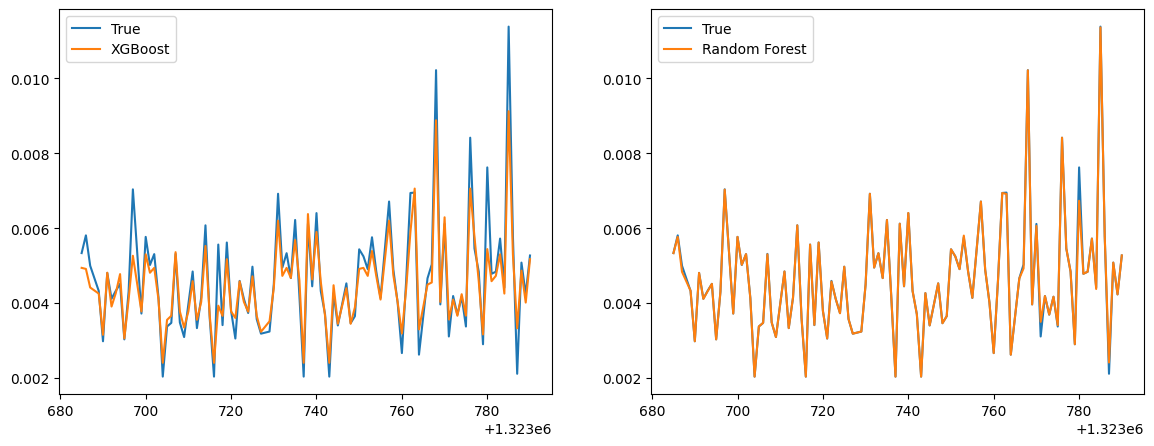

In [156]:
models_names = ['XGBoost','Random Forest']

# prediction test
fig, axs = plt.subplots(1, 2, figsize=(14,5))
axs = axs.flatten()

for i, ax in zip(models_names, axs):
    ax.plot(two_models_results['y_train_pred']['consum_energia_final'][-100:], label='True')
    ax.plot(two_models_results['y_train_pred'][i][-100:], label=i)
    ax.legend(loc='upper left')

In [159]:
two_models_results['y_train_pred']

,consum_energia_final,Random Forest,XGBoost
0,0.005013,0.005013,0.004831
1,0.006034,0.006035,0.006200
2,0.004238,0.004238,0.004702
3,0.002275,0.002275,0.002739
4,0.003051,0.003059,0.003057
...,...,...,...
1323786,0.005788,0.005787,0.005302
1323787,0.002114,0.002415,0.003328
1323788,0.005081,0.005080,0.004867
1323789,0.004233,0.004233,0.004015


In [161]:
y_test_pred

,consum_energia_final,Random Forest,XGBoost,any_construccio_lri
75567,0.003852,0.003847,0.004031,1986.861938
383030,0.007181,0.008071,0.005499,1991.587769
1200685,0.004865,0.004865,0.004585,1972.422363
230123,0.006138,0.006136,0.005525,1981.910522
996165,0.002038,0.002038,0.002406,1967.354126
...,...,...,...,...
68177,0.004398,0.004395,0.004398,2003.720093
699059,0.005531,0.005529,0.003931,1956.758667
507464,0.004175,0.004175,0.004522,1965.981445
838829,0.003726,0.003723,0.003188,1962.082642


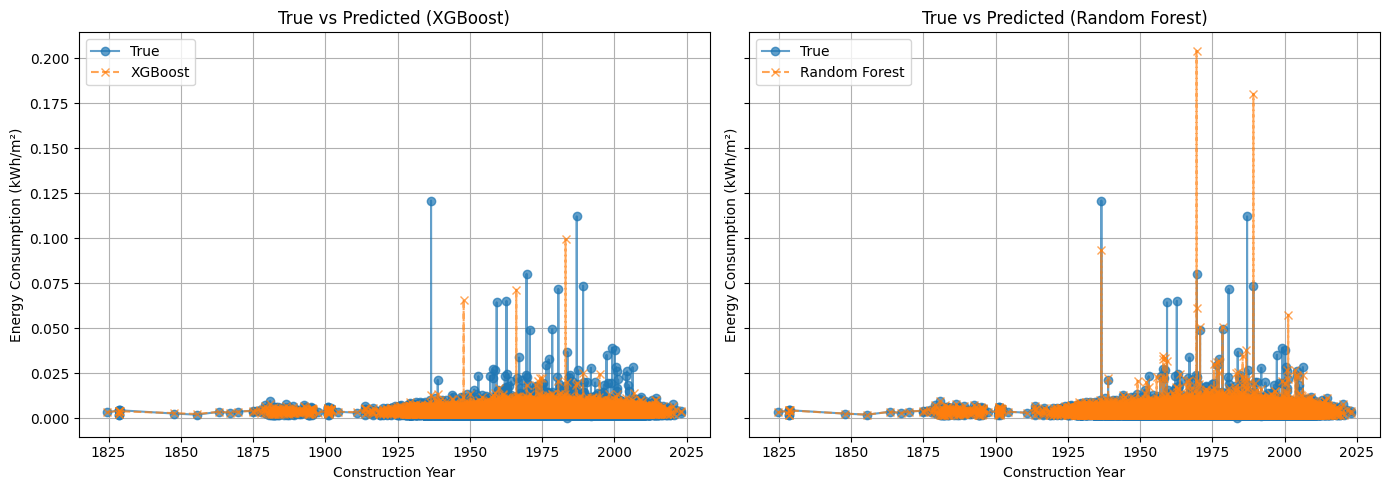

In [ ]:

models_names = ['XGBoost', 'Random Forest']

# Sort values by construction year
y_test_pred_sorted = y_test_pred.sort_values(by='any_construccio_lri')

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
axs = axs.flatten()

for i, ax in zip(models_names, axs):
    ax.plot(y_test_pred_sorted['any_construccio_lri'], 
            y_test_pred_sorted['consum_energia_final'], 
            label='True', marker='o', linestyle='-', alpha=0.7)
    
    ax.plot(y_test_pred_sorted['any_construccio_lri'], 
            y_test_pred_sorted[i], 
            label=i, marker='x', linestyle='--', alpha=0.7)

    ax.set_xlabel("Construction Year")
    ax.set_ylabel("Energy Consumption (kWh/m²)")
    ax.set_title(f"True vs Predicted ({i})")
    ax.legend(loc='upper left')
    ax.grid(True)

plt.tight_layout()
plt.show()


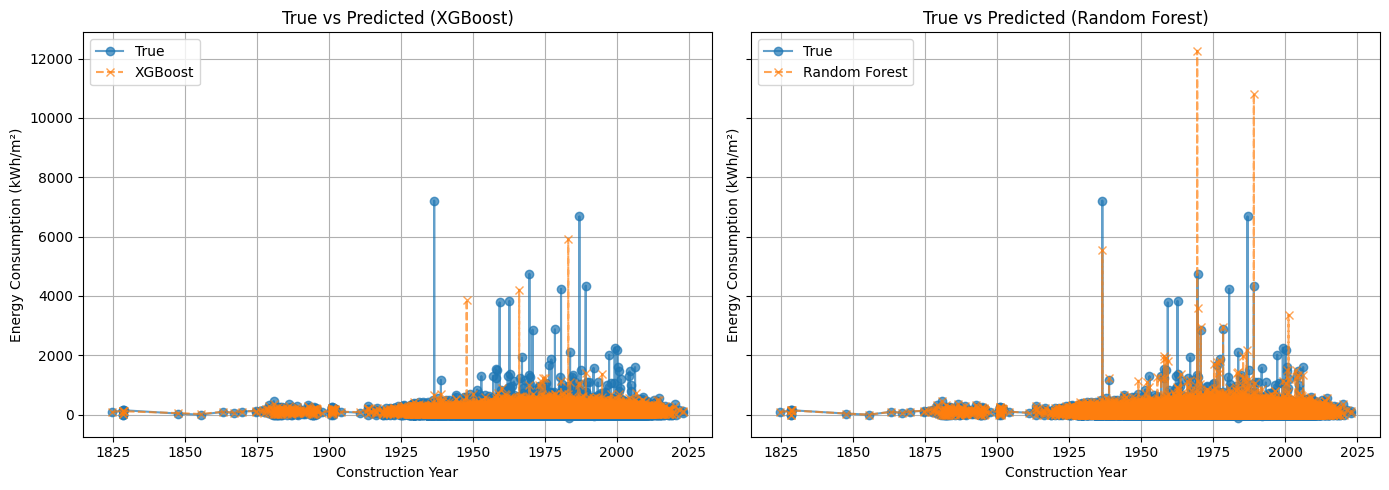

In [164]:

y_scaler = two_models_results['y_scaler']

# Inverse transform energy consumption values
y_test_pred_sorted = y_test_pred.sort_values(by='any_construccio_lri').copy()
y_test_pred_sorted[['consum_energia_final', 'XGBoost', 'Random Forest']] = y_scaler.inverse_transform(
    y_test_pred_sorted[['consum_energia_final', 'XGBoost', 'Random Forest']]
)

models_names = ['XGBoost', 'Random Forest']

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
axs = axs.flatten()

for i, ax in zip(models_names, axs):
    ax.plot(y_test_pred_sorted['any_construccio_lri'], 
            y_test_pred_sorted['consum_energia_final'], 
            label='True', marker='o', linestyle='-', alpha=0.7)
    
    ax.plot(y_test_pred_sorted['any_construccio_lri'], 
            y_test_pred_sorted[i], 
            label=i, marker='x', linestyle='--', alpha=0.7)

    ax.set_xlabel("Construction Year")
    ax.set_ylabel("Energy Consumption (kWh/m²)")
    ax.set_title(f"True vs Predicted ({i})")
    ax.legend(loc='upper left')
    ax.grid(True)

plt.tight_layout()
plt.show()


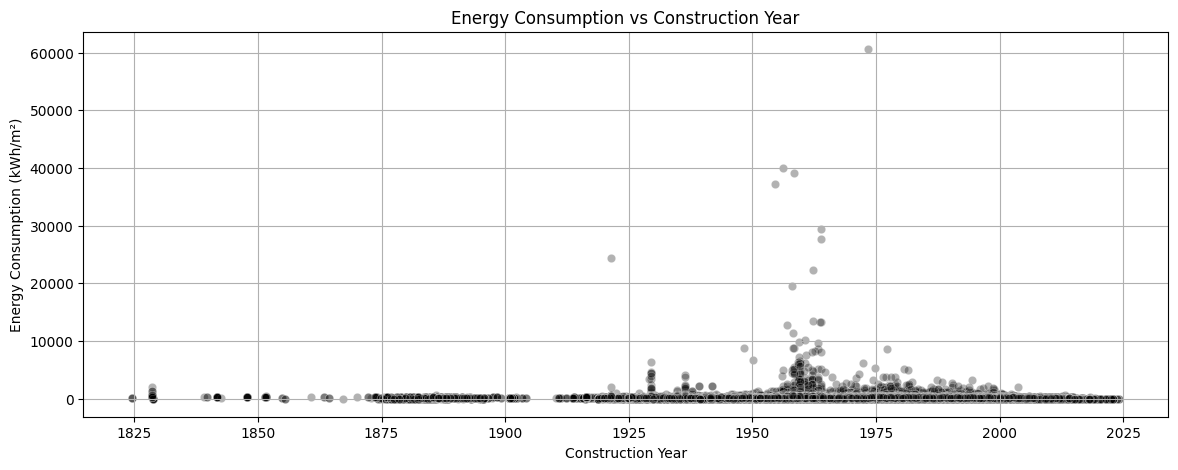

In [138]:


plt.figure(figsize=(14, 5))

sns.scatterplot(data=df, x="any_construccio_lri", y="consum_energia_final", 
                color="black", alpha=0.3)

# Labels and title
plt.title("Energy Consumption vs Construction Year")
plt.xlabel("Construction Year")
plt.ylabel("Energy Consumption (kWh/m²)")
plt.grid(True)

plt.show()


In [ ]:
y_test_pred

,consum_energia_final,Random Forest,XGBoost,any_construccio_lri,Random Forest_error,XGBoost_error,any_construccio_lri_error
312978,0.004699,0.004699,0.004670,1977.951782,0.00,0.61,42094434.37
1067861,0.005665,0.005665,0.005302,1962.119507,0.00,6.40,34634603.74
1081818,0.005329,0.005333,0.005302,2002.249756,0.07,0.50,37573692.02
993345,0.005994,0.005993,0.005525,1959.731689,0.03,7.82,32693300.40
1051508,0.004587,0.004587,0.004385,1966.620117,0.01,4.39,42878341.73
...,...,...,...,...,...,...,...
839891,0.003927,0.003926,0.003888,1997.051147,0.01,0.99,50858484.93
535030,0.004626,0.004624,0.004385,1996.327881,0.06,5.21,43152588.01
573977,0.005143,0.005301,0.005064,1993.357178,3.07,1.55,38756895.67
1238212,0.004966,0.004990,0.004867,1962.737427,0.48,2.00,39520853.59


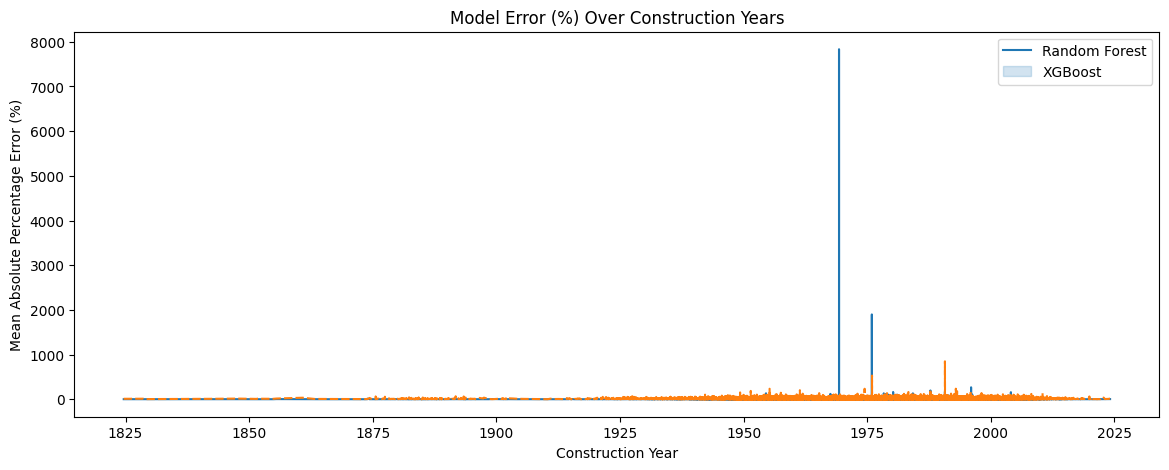

In [127]:
# Aggregate mean error by construction year
error_by_year = error_perc_change.groupby("any_construccio_lri")[["Random Forest_error", "XGBoost_error"]].mean()

# Plot error trends over time
plt.figure(figsize=(14, 5))
sns.lineplot(data=error_by_year)
plt.title("Model Error (%) Over Construction Years")
plt.xlabel("Construction Year")
plt.ylabel("Mean Absolute Percentage Error (%)")
plt.legend(["Random Forest", "XGBoost"])
plt.show()


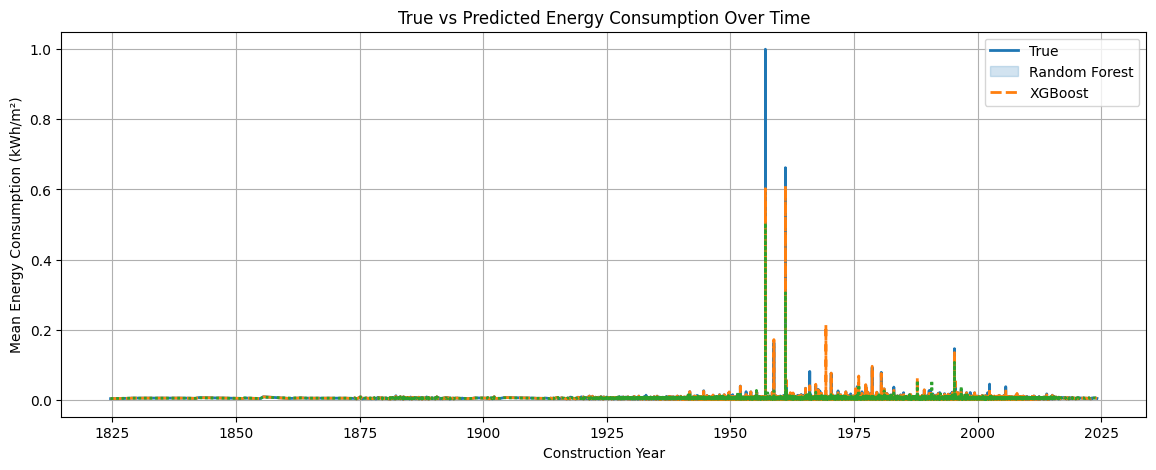

In [134]:
# Aggregate mean values by construction year
df_plot = error_perc_change.groupby("any_construccio_lri")[["consum_energia_final", "Random Forest", "XGBoost"]].mean()

# Plot actual vs predicted values over time
plt.figure(figsize=(14, 5))
sns.lineplot(data=df_plot, linewidth=2)

# Add labels and title
plt.title("True vs Predicted Energy Consumption Over Time")
plt.xlabel("Construction Year")
plt.ylabel("Mean Energy Consumption (kWh/m²)")
plt.legend(["True", "Random Forest", "XGBoost"])
plt.grid(True)

# Show the plot
plt.show()


In [ ]:
# df['r']

In [10]:
all_results =  train_energy_consumption_models(
    df,
    models,
    target,
    num_features_all,
    cat_features_all,
    save_path,
    scale=True,
    shuffle=True,
    stratify=False,
    save=False,
    test_size=0.1
    )

print("Train Scores:", all_results['train_scores_df'])
print("Test Scores:", all_results['test_scores_df'])


🔹 Encoding categorical variables...


Training Models:   0%|          | 0/10 [00:00<?, ?it/s]


🔹 Training Random Forest...


Training Models:  10%|█         | 1/10 [01:05<09:50, 65.60s/it]


🔹 Training Gradient Boosting...


Training Models:  20%|██        | 2/10 [02:04<08:13, 61.67s/it]


🔹 Training HistGradient Boosting...


Training Models:  30%|███       | 3/10 [02:06<04:01, 34.47s/it]


🔹 Training XGBoost...


Training Models:  40%|████      | 4/10 [02:08<02:09, 21.64s/it]


🔹 Training LightGBM...


Training Models:  50%|█████     | 5/10 [02:09<01:11, 14.31s/it]


🔹 Training Ridge Regression...


Training Models:  60%|██████    | 6/10 [02:10<00:38,  9.62s/it]


🔹 Training Lasso Regression...


Training Models:  70%|███████   | 7/10 [02:10<00:19,  6.65s/it]


🔹 Training ElasticNet...


Training Models:  80%|████████  | 8/10 [02:11<00:09,  4.65s/it]


🔹 Training Stacked Model...


Training Models:  90%|█████████ | 9/10 [07:56<01:50, 110.96s/it]


🔹 Training Voting Model...


Training Models: 100%|██████████| 10/10 [08:52<00:00, 53.27s/it]

Train Scores:                             MAE      RMSE        R²
Random Forest          0.000026  0.000670  0.916913
Gradient Boosting      0.000769  0.001626  0.510631
HistGradient Boosting  0.000725  0.001906  0.327396
XGBoost                0.000742  0.001952  0.294892
LightGBM               0.000742  0.001963  0.286864
Ridge Regression       0.000623  0.001936  0.306360
Lasso Regression       0.001091  0.002324  0.000000
ElasticNet             0.001091  0.002324  0.000000
Stacked Model          0.000206  0.000868  0.860558
Voting Model           0.000751  0.001829  0.380456
Test Scores:                             MAE      RMSE        R²
Random Forest          0.000060  0.000694  0.811128
Gradient Boosting      0.000768  0.001219  0.416601
HistGradient Boosting  0.000723  0.001172  0.460190
XGBoost                0.000739  0.001203  0.431544
LightGBM               0.000739  0.001205  0.429968
Ridge Regression       0.000618  0.001050  0.567301
Lasso Regression       0.001088  0.00

In [13]:
import joblib  # Efficient for saving large objects
import os

# Define the save path for results
results_save_path = os.path.join(save_path,"all_results.pkl")

# Save all results
joblib.dump(all_results, results_save_path)
print(f"🔹 Results saved to {results_save_path}")



🔹 Results saved to ../outputs/checkpoint/all/all_results.pkl


In [14]:
# Load the saved results
loaded_results = joblib.load(results_save_path)

# Print Train & Test Scores from loaded results
print("\n🔹 Loaded Train Scores:\n", loaded_results["train_scores_df"])
print("\n🔹 Loaded Test Scores:\n", loaded_results["test_scores_df"])



🔹 Loaded Train Scores:
                             MAE      RMSE        R²
Random Forest          0.000026  0.000670  0.916913
Gradient Boosting      0.000769  0.001626  0.510631
HistGradient Boosting  0.000725  0.001906  0.327396
XGBoost                0.000742  0.001952  0.294892
LightGBM               0.000742  0.001963  0.286864
Ridge Regression       0.000623  0.001936  0.306360
Lasso Regression       0.001091  0.002324  0.000000
ElasticNet             0.001091  0.002324  0.000000
Stacked Model          0.000206  0.000868  0.860558
Voting Model           0.000751  0.001829  0.380456

🔹 Loaded Test Scores:
                             MAE      RMSE        R²
Random Forest          0.000060  0.000694  0.811128
Gradient Boosting      0.000768  0.001219  0.416601
HistGradient Boosting  0.000723  0.001172  0.460190
XGBoost                0.000739  0.001203  0.431544
LightGBM               0.000739  0.001205  0.429968
Ridge Regression       0.000618  0.001050  0.567301
Lasso Regressio

The model evaluation results show both **Train Scores** and **Test Scores** for each model:  

🔹 **Observations:**  
1. **Overfitting in Random Forest:**  
   - **Train R²:** 0.9169 (very high)  
   - **Test R²:** 0.8111 (still high, but lower than Train)  
   - The gap between train and test suggests slight overfitting.  

2. **Stacked Model Performs Well:**  
   - **Train R²:** 0.8606  
   - **Test R²:** 0.8258 (smallest gap between train and test)  
   - Suggests a good generalization ability.  

3. **Lasso and ElasticNet Perform Poorly:**  
   - **Train/Test R²:** ~0.00  
   - Suggests that they are not capturing the signal in the data effectively.  

4. **Gradient Boosting & XGBoost Are Strong Contenders:**  
   - Gradient Boosting: **Train R²:** 0.5106 → **Test R²:** 0.4166  
   - XGBoost: **Train R²:** 0.2949 → **Test R²:** 0.4315  
   - Generally good performance, but could benefit from hyperparameter tuning.  

---

'consum_energia_final'

In [ ]:

# def one_hot_encode(df, columns=None, drop_first=True):
#     """
#     One-hot encodes specified categorical columns in a DataFrame.

#     Args:
#         df (pd.DataFrame): Input DataFrame.
#         columns (list, optional): List of categorical columns to encode. If None, detects categorical columns automatically.
#         drop_first (bool, optional): Whether to drop the first category to avoid multicollinearity (default: True).

#     Returns:
#         pd.DataFrame: DataFrame with one-hot encoded columns.
#     """
#     if columns is None:
#         columns = df.select_dtypes(include=["object", "category"]).columns.tolist()
    
#     if not columns:
#         print("⚠️ No categorical columns to encode.")
#         return df

#     print(f"🔹 One-hot encoding columns: {columns}")

#     return pd.get_dummies(df, columns=columns, drop_first=drop_first)

# df = catalonia_analysis_df.copy()

# model_num_cols = df.select_dtypes(include='number').columns.tolist()
# num_cols = ["emissions_calefaccio","energia_primaria_no_renovable","valor_aïllaments","emissions_acs","emissions_co2","energia_acs","latitud","cost_m2"]
# model_cat_cols = ['qualificacio_energia_calefaccio']
# target = ['consum_energia_final']

# # df = df[model_num_cols + model_cat_cols + target]
# df = df[model_num_cols + model_cat_cols]

# df = one_hot_encode(df, columns=model_cat_cols)

# df.head()


In [ ]:
# target = 'consum_energia_final'

# X = df[model_num_cols + model_cat_cols]
# y = df[[target]]

# model = xgboost.XGBRegressor().fit(X, y)
# explainer = shap.Explainer(model)
# shap_values = explainer(X)
# shap.plots.waterfall(shap_values[0])

In [30]:
all_results['test_scores_df']

,MAE,RMSE,R²
Random Forest,0.000060,0.000694,0.811128
Gradient Boosting,0.000768,0.001219,0.416601
HistGradient Boosting,0.000723,0.001172,0.460190
XGBoost,0.000739,0.001203,0.431544
LightGBM,0.000739,0.001205,0.429968
Ridge Regression,0.000618,0.001050,0.567301
Lasso Regression,0.001088,0.001596,-0.000011
ElasticNet,0.001088,0.001596,-0.000011
Stacked Model,0.000222,0.000666,0.825841
Voting Model,0.000748,0.001205,0.429681


In [ ]:
error_perc_change = all_results['test_scores_df'].copy()
for c in error_perc_change:
    error_perc_change[f'{c}_error'] = round(abs(error_perc_change[c] - error_perc_change['consum_energia_final'])/error_perc_change['consum_energia_final'] * 100, 2)
error_perc_change.drop('consum_energia_final_error', axis=1, inplace=True)
error_perc_change

In [ ]:
# train an XGBoost model
X, y = shap.datasets.california()
model = xgboost.XGBRegressor().fit(X, y)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])


In [ ]:
# rf_explanations = explain_model_with_shap_lime(
#     model= all_results['trained_models']['Random Forest'],
#     X_train = all_results['X_train'],
#     X_test = all_results['X_test'],
#     sample_idx=5
#     )

# rf_explanations


🔹 Generating SHAP explanations...



In [ ]:
all_results['predictors']

In [ ]:
# model = all_results['trained_models']['Gradient Boosting']
# X = all_results['predictors']
# gb_explainer = shap.Explainer(model)
# shap_values = explainer(X)

# # visualize the first prediction's explanation
# shap.plots.waterfall(shap_values[0])

In [ ]:
df['consum_energia_final'].describe()

- V1 trains the models using the important features selected by the algorithm during training

🔹 Top Features from Random Forest: ['emissions_co2', 'energia_primaria_no_renovable', 'cost_anual_energia_habitatge', 'cost_m2', 'sistema_biomassa', 'emissions_calefaccio', 'actuacions_rehabilitacio_ml', 'any_construccio_lri', 'valor_finestres_cte', 'latitud']
🔹 Numerical Features: ['emissions_co2', 'energia_primaria_no_renovable', 'cost_anual_energia_habitatge', 'cost_m2', 'sistema_biomassa', 'emissions_calefaccio', 'actuacions_rehabilitacio_ml', 'any_construccio_lri', 'valor_finestres_cte', 'latitud']
🔹 Categorical Features: []

🔹 Encoding categorical variables...


Encoding Progress: 0it [00:00, ?it/s]
Training Models:   0%|          | 0/1 [00:00<?, ?it/s]


🔹 Training Random Forest...


/Users/okpo/Desktop/Onward/net_zero_env/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


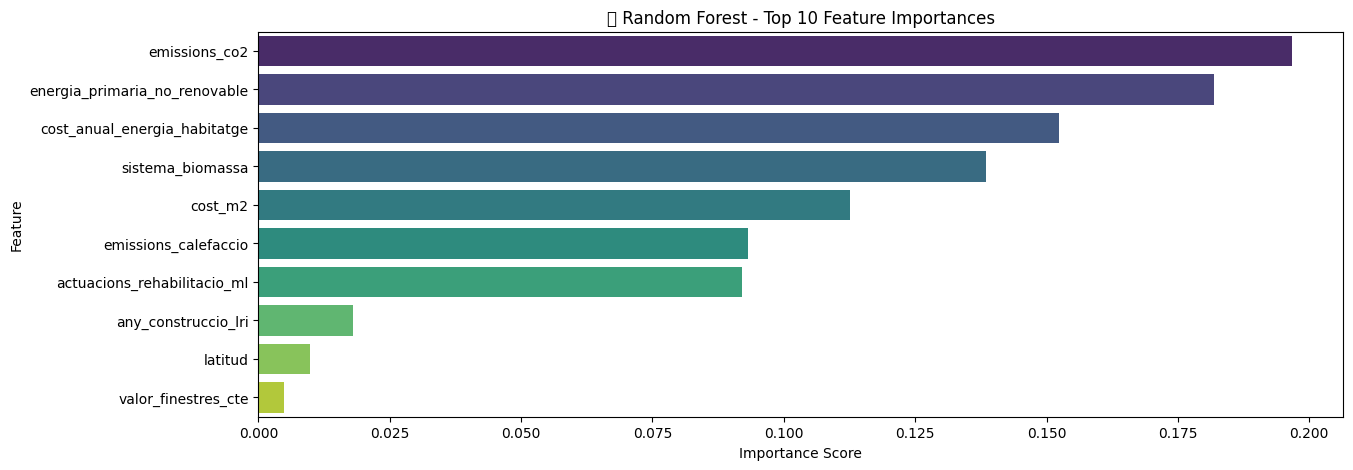

Training Models: 100%|██████████| 1/1 [00:29<00:00, 29.20s/it]


🔹 Model Performance Comparison:
                    MAE        RMSE        R²
Random Forest  3.790394  3270.52332  0.748501


In [ ]:
# Extract top feature names from Random Forest importance
feature_importances_rf = all_feature_importances["Random Forest"]["Feature"].tolist()

# Separate features into numerical and categorical
rf_num_cols = [col for col in feature_importances_rf if np.issubdtype(df[col].dtype, np.number)]
rf_cat_cols = [col for col in feature_importances_rf if not np.issubdtype(df[col].dtype, np.number)]

# Print the results
print("🔹 Top Features from Random Forest:", feature_importances_rf)
print("🔹 Numerical Features:", rf_num_cols)
print("🔹 Categorical Features:", rf_cat_cols)


save_path = "../outputs/checkpoint/v1"
rf_model = {
        "Random Forest": RandomForestRegressor(n_estimators=5, random_state=7, n_jobs=-1),
        # "XGBoost": XGBRegressor(n_estimators=5, random_state=7, objective="reg:squarederror", tree_method="hist"),
    }
rf_v1_results_df, rf_v1_trained_models, rf_v1_feature_importances, rf_v1_label_encoders = \
train_energy_consumption_models(df, rf_model, target, rf_num_cols, rf_cat_cols, save_path)


In [ ]:
# Extract top feature names from Random Forest importance
feature_importances_xgb = all_feature_importances["XGBoost"]["Feature"].tolist()

# Separate features into numerical and categorical
xgb_num_cols = [col for col in feature_importances_xgb if np.issubdtype(df[col].dtype, np.number)]
xgb_cat_cols = [col for col in feature_importances_xgb if not np.issubdtype(df[col].dtype, np.number)]

# Print the results
print("🔹 Top Features from XGBoost:", feature_importances_xgb)
print("🔹 Numerical Features:", xgb_num_cols)
print("🔹 Categorical Features:", xgb_cat_cols)


save_path = "../outputs/checkpoint/v1"
xgb_model = {
        # "Random Forest": RandomForestRegressor(n_estimators=5, random_state=7, n_jobs=-1),
        "XGBoost": XGBRegressor(n_estimators=5, random_state=7, objective="reg:squarederror", tree_method="hist"),
    }
xgb_v1_results_df, xgb_v1_trained_models, xgb_v1_feature_importances, xgb_v1_label_encoders = \
train_energy_consumption_models(df, xgb_model, target, xgb_num_cols, xgb_cat_cols, save_path)


In [ ]:
print("numeric_cols:", numeric_cols)

print("cat_cols:", cat_cols)

numeric_cols: Index(['metres_cadastre', 'energia_primaria_no_renovable', 'emissions_co2',
       'consum_energia_final', 'cost_anual_energia_habitatge',
       'any_construccio_lri', 'valor_aïllaments', 'valor_finestres',
       'valor_finestres_cte', 'any_construccio_mbi', 'energia_acs',
       'energia_enllumenament', 'emissions_calefaccio',
       'emissions_refrigeracio', 'emissions_acs', 'emissions_enllumenament',
       'latitud', 'longitud', 'cost_m2'],
      dtype='object')
cat_cols: Index(['rehabilitacio_energetica', 'qualificacio_energia_calefaccio',
       'qualificacio_energia_refrigeracio', 'qualificacio_energia_acs',
       'actuacions_rehabilitacio_ml', 'solar_termica', 'solar_fotovoltaica',
       'sistema_biomassa', 'energia_geotermica', 'tipus_tramit',
       'normativa_construccio', 'us_edifici', 'poblacio', 'comarca',
       'nom_provincia'],
      dtype='object')


In [ ]:
catalonia_analysis_df['us_edifici'].unique()

['Vivienda individual en bloque de viviendas', 'Habitatge unifamiliar', 'Terciari', 'Habitatge individual en bloc d'habitatges', 'Bloc d'habitatges plurifamiliar', ..., 'Bloc d'habitatges', 'Terciario', 'Bloque de viviendas plurifamiliar', 'Bloque de viviendas', 'Habitatge Unifamiliar']
Length: 11
Categories (11, object): ['Bloc d'habitatges', 'Bloc d'habitatges plurifamiliar', 'Bloque de viviendas', 'Bloque de viviendas plurifamiliar', ..., 'Terciari', 'Terciario', 'Vivienda individual en bloque de viviendas', 'Vivienda unifamiliar']

In [ ]:
catalonia_analysis_df.isnull().mean().sum()

0.0

In [ ]:
# df = catalonia_analysis_df.copy()
df

,metres_cadastre,energia_primaria_no_renovable,rehabilitacio_energetica,emissions_co2,consum_energia_final,cost_anual_energia_habitatge,any_construccio_lri,valor_aïllaments,valor_finestres,valor_finestres_cte,...,emissions_calefaccio,emissions_refrigeracio,emissions_acs,emissions_enllumenament,latitud,longitud,poblacio,comarca,nom_provincia,cost_m2
index,,,,,,,,,,,,,,,,,,,,,
0,55.00,261.50,0,50.33,180.63,16.90,1978.053589,0.73,3.78,2.1,...,30.160000,0.91,19.270000,0.00,41.443798,2.138852,354,2,1,0.307273
1,116.00,289.13,0,75.53,242.61,18.39,1993.678101,2.94,5.00,2.1,...,69.160004,1.32,5.050000,0.00,41.443798,2.138852,1134,2,1,0.158534
2,122.00,260.98,0,44.21,133.56,21.18,1979.498291,1.19,3.66,2.1,...,35.500000,3.96,4.740000,0.00,41.443798,2.138852,64,12,3,0.173607
3,104.00,28.12,0,4.76,14.39,2.28,2005.651367,0.43,2.88,2.1,...,2.540000,1.13,1.110000,0.00,41.443798,2.138852,64,12,3,0.021923
4,1730.00,24.76,0,4.24,61.51,8.77,1986.248291,0.30,2.04,2.1,...,0.290000,0.78,2.960000,2.21,41.443798,2.138852,1135,2,1,0.005069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1336920,55.00,273.01,0,57.59,227.68,777.46,1975.532715,2.23,5.59,2.1,...,45.299999,0.90,11.390000,0.00,41.542538,2.425606,555,37,0,14.135636
1336921,49.00,227.94,0,47.61,4.60,15.26,1980.406372,2.45,5.70,2.1,...,27.770000,2.64,17.200001,0.00,41.540436,2.426638,555,37,0,0.311429
1336922,85.25,223.80,0,47.20,184.72,951.88,1981.466675,1.69,3.78,2.1,...,37.830002,0.68,8.720000,0.00,41.489693,2.040995,800,67,0,11.165748


In [ ]:
df[numeric_cols].corr(method='pearson')[target].sort_values(ascending=False).to_frame().T

,consum_energia_final,emissions_calefaccio,energia_primaria_no_renovable,valor_aïllaments,emissions_acs,emissions_co2,energia_acs,latitud,cost_m2,emissions_enllumenament,energia_enllumenament,cost_anual_energia_habitatge,emissions_refrigeracio,any_construccio_mbi,valor_finestres,metres_cadastre,longitud,any_construccio_lri,valor_finestres_cte
consum_energia_final,1.0,0.42713,0.310403,0.244615,0.129231,0.11738,0.113749,0.101964,0.100758,0.0964,0.094881,0.093303,0.083056,0.078032,0.001902,-0.010298,-0.011312,-0.037037,-0.049406


In [ ]:
catalonia_analysis_df['rehabilitacio_energetica']

In [ ]:

# numeric_cols: Index(['metres_cadastre', 'energia_primaria_no_renovable', 'emissions_co2',
#        'consum_energia_final', 'cost_anual_energia_habitatge',
#        'any_construccio_lri', 'valor_aïllaments', 'valor_finestres',
#        'valor_finestres_cte', 'any_construccio_mbi', 'energia_acs',
#        'energia_enllumenament', 'emissions_calefaccio',
#        'emissions_refrigeracio', 'emissions_acs', 'emissions_enllumenament',
#        'latitud', 'longitud', 'cost_m2'],
#       dtype='object')
# cat_cols: Index(['rehabilitacio_energetica', 'qualificacio_energia_calefaccio',
#        'qualificacio_energia_refrigeracio', 'qualificacio_energia_acs',
#        'actuacions_rehabilitacio_ml', 'solar_termica', 'solar_fotovoltaica',
#        'sistema_biomassa', 'energia_geotermica', 'tipus_tramit',
#        'normativa_construccio', 'us_edifici', 'poblacio', 'comarca',
#        'nom_provincia'],
#       dtype='object')

def one_hot_encode(df, columns=None, drop_first=True):
    """
    One-hot encodes specified categorical columns in a DataFrame.

    Args:
        df (pd.DataFrame): Input DataFrame.
        columns (list, optional): List of categorical columns to encode. If None, detects categorical columns automatically.
        drop_first (bool, optional): Whether to drop the first category to avoid multicollinearity (default: True).

    Returns:
        pd.DataFrame: DataFrame with one-hot encoded columns.
    """
    if columns is None:
        columns = df.select_dtypes(include=["object", "category"]).columns.tolist()
    
    if not columns:
        print("⚠️ No categorical columns to encode.")
        return df

    print(f"🔹 One-hot encoding columns: {columns}")

    return pd.get_dummies(df, columns=columns, drop_first=drop_first)

df = catalonia_analysis_df.copy()

model_num_cols = df.select_dtypes(include='number').columns.tolist()
num_cols = ["emissions_calefaccio","energia_primaria_no_renovable","valor_aïllaments","emissions_acs","emissions_co2","energia_acs","latitud","cost_m2"]
model_cat_cols = ['qualificacio_energia_calefaccio']
target = ['consum_energia_final']

# df = df[model_num_cols + model_cat_cols + target]
df = df[model_num_cols + model_cat_cols]

df = one_hot_encode(df, columns=model_cat_cols)

df.head()


🔹 One-hot encoding columns: ['qualificacio_energia_calefaccio']


,metres_cadastre,energia_primaria_no_renovable,emissions_co2,consum_energia_final,cost_anual_energia_habitatge,any_construccio_lri,valor_aïllaments,valor_finestres,valor_finestres_cte,any_construccio_mbi,...,emissions_enllumenament,latitud,longitud,cost_m2,qualificacio_energia_calefaccio_B,qualificacio_energia_calefaccio_C,qualificacio_energia_calefaccio_D,qualificacio_energia_calefaccio_E,qualificacio_energia_calefaccio_F,qualificacio_energia_calefaccio_G
index,,,,,,,,,,,,,,,,,,,,,
0,55.0,261.50,50.33,180.63,16.90,1978.053589,0.73,3.78,2.1,1977.0,...,0.00,41.443798,2.138852,0.307273,False,False,False,True,False,False
1,116.0,289.13,75.53,242.61,18.39,1993.678101,2.94,5.00,2.1,2002.5,...,0.00,41.443798,2.138852,0.158534,False,False,False,False,True,False
2,122.0,260.98,44.21,133.56,21.18,1979.498291,1.19,3.66,2.1,2003.0,...,0.00,41.443798,2.138852,0.173607,False,False,False,False,True,False
3,104.0,28.12,4.76,14.39,2.28,2005.651367,0.43,2.88,2.1,2003.0,...,0.00,41.443798,2.138852,0.021923,False,False,False,False,False,False
4,1730.0,24.76,4.24,61.51,8.77,1986.248291,0.30,2.04,2.1,1985.0,...,2.21,41.443798,2.138852,0.005069,False,False,False,False,False,False


In [ ]:
df[model_num_cols].corr(method='pearson')['consum_energia_final'].sort_values(ascending=False).to_frame().T

,consum_energia_final,emissions_calefaccio,energia_primaria_no_renovable,valor_aïllaments,emissions_acs,emissions_co2,energia_acs,latitud,cost_m2,emissions_enllumenament,energia_enllumenament,cost_anual_energia_habitatge,emissions_refrigeracio,any_construccio_mbi,valor_finestres,metres_cadastre,longitud,any_construccio_lri,valor_finestres_cte
consum_energia_final,1.0,0.42713,0.310403,0.244615,0.129231,0.11738,0.113749,0.101964,0.100758,0.0964,0.094881,0.093303,0.083056,0.078032,0.001902,-0.010298,-0.011312,-0.037037,-0.049406


In [ ]:

import time
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import shap
import lime
import lime.lime_tabular
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display

def train_model_pipelines_with_early_stopping(
    df, models, target, scale=True, shuffle=True, output_dir=None
):
    """
    Train multiple models on the given dataset, including comparisons of models with and without early stopping.

    Args:
        df (pd.DataFrame): The input dataset.
        models (list): List of tuples with model names and model instances.
        target (str): Target column name.
        scale (bool): Whether to scale features and target variable.
        category (str): Category of models (used for tqdm description).
        shuffle (bool): Whether to shuffle the data before splitting.
        output_dir (str): Directory to save model checkpoints.

    Returns:
        dict: A dictionary containing training/validation/testing scores, staged predictions,
              training times, and number of estimators for each model.
    """


    # Scalers for features and target
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    predictors = df.drop(target, axis=1)

    # Scale features and target variable
    if scale:
        predictors = pd.DataFrame(x_scaler.fit_transform(predictors), columns=predictors.columns)
        target = pd.DataFrame(y_scaler.fit_transform(df[[target]]), columns=[target])
    else:
        predictors = pd.DataFrame(predictors, columns=predictors.columns)
        target = pd.DataFrame(df[[target]], columns=[target])

    # Split into train, validation, and test sets
    train_size = int(len(predictors) * 0.8)
    val_size = int(len(predictors) * 0.25)

    if shuffle:
        x_train, x_temp, y_train, y_temp = train_test_split(predictors, target, test_size=0.2, random_state=42)
        x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.2, random_state=42)
    else:
        x_train, x_temp = predictors[:train_size], predictors[train_size:]
        y_train, y_temp = target[:train_size], target[train_size:]
        val_end = train_size + val_size
        x_val, x_test = predictors[train_size:val_end], predictors[val_end:]
        y_val, y_test = target[train_size:val_end], target[val_end:]
    
    metrics = ['mean_absolute_error', 'r2_score', 'mean_squared_error']

    # Initialize dictionaries for scores, predictions, training times, and estimators
    train_scores, val_scores, test_scores = {}, {}, {}
    staged_predictions = {"train": {}, "val": {}}
    training_times = {}
    n_estimators = {}
    trained_models = {}  # Store trained models
    
    train_df = y_train.copy()
    val_df = y_val.copy()
    test_df = y_test.copy()

    # Train and evaluate models
    for model_name, model in tqdm(models, total=len(models), desc=f"Training Models"):
        if isinstance(model, (XGBRegressor, LGBMRegressor)):
            model.set_params(eval_set=[(x_val, y_val)])  # Set validation data for early stopping
        print(f"\nTraining {model_name}...")
        model_output_dir = os.path.join(output_dir, model_name) if output_dir else None
        if model_output_dir:
            os.makedirs(model_output_dir, exist_ok=True)

        # Measure training time
        start_time = time.time()
        model.fit(x_train, y_train)
        trained_models[model_name] = model  # Store the trained model
        training_time = time.time() - start_time
        training_times[model_name] = training_time

        # Track the number of estimators (if applicable)
        if hasattr(model, "n_estimators_"):
            n_estimators[model_name] = model.n_estimators_
        else:
            n_estimators[model_name] = len(list(getattr(model, "staged_predict", lambda x: [])(x_train)))

        # Save predictions
        train_df[model_name] = model.predict(x_train).flatten()
        val_df[model_name] = model.predict(x_val).flatten()
        test_df[model_name] = model.predict(x_test).flatten()
        
        if hasattr(model, "staged_predict"):
            staged_predictions["train"][model_name] = list(model.staged_predict(x_train))
            staged_predictions["val"][model_name] = list(model.staged_predict(x_val))
            n_estimators[model_name] = len(staged_predictions["train"][model_name])
        else:
            n_estimators[model_name] = len(list(getattr(model, "staged_predict", lambda x: [])(x_train)))


        # Save the trained model
        if model_output_dir:
            model_path = os.path.join(model_output_dir, f"{model_name}_model.pkl")
            joblib.dump(model, model_path)

        # Calculate scores
        train_scores[model_name] = []
        val_scores[model_name] = []
        test_scores[model_name] = []

        for metric in metrics:
            train_scores[model_name].append(eval(metric)(train_df[model_name], y_train))
            val_scores[model_name].append(eval(metric)(val_df[model_name], y_val))
            test_scores[model_name].append(eval(metric)(test_df[model_name], y_test))

    # Convert scores to DataFrames
    train_scores_df = pd.DataFrame(train_scores, index=metrics).T
    # val_scores_df = pd.DataFrame(val_scores, index=metrics).T
    test_scores_df = pd.DataFrame(test_scores, index=metrics).T
    
    # Collect reusable return parameters into a dictionary
    results = {
        "trained_model": trained_models,
        "x_train": x_train,
        "x_val": x_val,
        "x_test": x_test,
        "y_train": y_train,
        "y_val": y_val,
        "y_test": y_test,
        "predictors": predictors,
        "train_scores_df": train_scores_df,
        # "val_scores_df": val_scores_df,
        "test_scores_df": test_scores_df,
        "staged_predictions": staged_predictions,
        "training_times": training_times,
        "n_estimators": n_estimators,
    }

    return results


def explain_model_with_shap_lime(model, X_train, X_test, sample_idx=0, num_features=10):
    """
    Explain a trained model using SHAP (global + local explanations) and LIME (local explanations),
    with interactive visualizations.

    Args:
        model (object): Trained model (e.g., XGBoost, LightGBM, RandomForest, etc.).
        X_train (pd.DataFrame or np.array): Training data (used for SHAP explainer).
        X_test (pd.DataFrame or np.array): Test data (used for generating explanations).
        sample_idx (int): Index of the test sample to explain using LIME.
        num_features (int): Number of top features to visualize.

    Returns:
        dict: Dictionary containing SHAP and LIME explanations.
    """

    print("\n🔹 Generating SHAP explanations...\n")
    
    # SHAP Explainer (Tree-based models vs others)
    if hasattr(model, "predict_proba") or hasattr(model, "feature_importances_"):
        explainer = shap.TreeExplainer(model)
    else:
        explainer = shap.Explainer(model, X_train)

    shap_values = explainer(X_test)

    ## ✅ SHAP Global Feature Importance (Static Plot)
    shap.summary_plot(shap_values, X_test, show=False)
    plt.title("SHAP Feature Importance (Global)")
    plt.show()

    ## ✅ SHAP Local Explanation (Interactive Force Plot)
    print(f"\n🔹 SHAP Explanation for Test Sample {sample_idx}\n")
    shap.initjs()  # Enables interactive visualizations
    display.display(shap.force_plot(explainer.expected_value, shap_values[sample_idx].values, X_test.iloc[sample_idx]))

    print("\n🔹 Generating LIME explanation...\n")

    ## ✅ LIME Explainer
    lime_explainer = lime.lime_tabular.LimeTabularExplainer(
        X_train.values if hasattr(X_train, 'values') else X_train, 
        feature_names=X_train.columns if hasattr(X_train, 'columns') else [f"Feature {i}" for i in range(X_train.shape[1])], 
        class_names=["Target"], 
        mode="regression" if hasattr(model, "predict") and not hasattr(model, "predict_proba") else "classification"
    )

    ## ✅ LIME Local Explanation (Interactive HTML)
    exp = lime_explainer.explain_instance(X_test.iloc[sample_idx].values, model.predict, num_features=num_features)
    html_exp = exp.as_html()
    display.display(display.HTML(html_exp))  # Render in a Jupyter Notebook

    return {
        "shap_values": shap_values,
        "lime_explanation": exp
    }

# def train_model_pipelines(
#     df, models, target, scale=True, shuffle=True, output_dir=None
# ):
#     """
#     Train multiple models on the given dataset.

#     Args:
#         df (pd.DataFrame): The input dataset.
#         models (list): List of tuples with model names and model instances.
#         target (str): Target column name.
#         scale (bool): Whether to scale features and target variable.
#         shuffle (bool): Whether to shuffle the data before splitting.
#         output_dir (str): Directory to save model checkpoints.

#     Returns:
#         dict: A dictionary containing training/testing scores, staged predictions,
#               training times, and number of estimators for each model.
#     """

#     # Scalers for features and target
#     x_scaler = MinMaxScaler()
#     y_scaler = MinMaxScaler()

#     predictors = df.drop(target, axis=1)

#     # Scale features and target variable
#     if scale:
#         predictors = pd.DataFrame(x_scaler.fit_transform(predictors), columns=predictors.columns)
#         target = pd.DataFrame(y_scaler.fit_transform(df[[target]]), columns=[target])
#     else:
#         predictors = pd.DataFrame(predictors, columns=predictors.columns)
#         target = pd.DataFrame(df[[target]], columns=[target])

#     # Split into train and test sets (no validation set)
#     train_size = int(len(predictors) * 0.9)

#     if shuffle:
#         x_train, x_test, y_train, y_test = train_test_split(predictors, target, test_size=0.1, random_state=42)
#     else:
#         x_train, x_test = predictors[:train_size], predictors[train_size:]
#         y_train, y_test = target[:train_size], target[train_size:]

#     metrics = ['mean_absolute_error', 'r2_score', 'mean_squared_error']

#     # Initialize dictionaries for scores, predictions, training times, and estimators
#     train_scores, test_scores = {}, {}
#     staged_predictions = {"train": {}}
#     training_times = {}
#     n_estimators = {}

#     train_df = y_train.copy()
#     test_df = y_test.copy()

#     # Train and evaluate models
#     for model_name, model in tqdm(models, total=len(models), desc=f"Training Models"):
#         print(f"\nTraining {model_name}...")
#         model_output_dir = os.path.join(output_dir, model_name) if output_dir else None
#         if model_output_dir:
#             os.makedirs(model_output_dir, exist_ok=True)

#         # Measure training time
#         start_time = time.time()
#         model.fit(x_train, y_train)
#         training_time = time.time() - start_time
#         training_times[model_name] = training_time

#         # Track the number of estimators (if applicable)
#         if hasattr(model, "n_estimators_"):
#             n_estimators[model_name] = model.n_estimators_
#         else:
#             n_estimators[model_name] = len(list(getattr(model, "staged_predict", lambda x: [])(x_train)))

#         # Save predictions
#         train_df[model_name] = model.predict(x_train).flatten()
#         test_df[model_name] = model.predict(x_test).flatten()
        
#         if hasattr(model, "staged_predict"):
#             staged_predictions["train"][model_name] = list(model.staged_predict(x_train))
#             n_estimators[model_name] = len(staged_predictions["train"][model_name])
#         else:
#             n_estimators[model_name] = len(list(getattr(model, "staged_predict", lambda x: [])(x_train)))

#         # Save the trained model
#         if model_output_dir:
#             model_path = os.path.join(model_output_dir, f"{model_name}_model.pkl")
#             joblib.dump(model, model_path)

#         # Calculate scores
#         train_scores[model_name] = []
#         test_scores[model_name] = []

#         for metric in metrics:
#             train_scores[model_name].append(eval(metric)(train_df[model_name], y_train))
#             test_scores[model_name].append(eval(metric)(test_df[model_name], y_test))

#     # Convert scores to DataFrames
#     train_scores_df = pd.DataFrame(train_scores, index=metrics).T
#     test_scores_df = pd.DataFrame(test_scores, index=metrics).T
    
#     # Collect reusable return parameters into a dictionary
#     results = {
#         "x_train": x_train,
#         "x_test": x_test,
#         "y_train": y_train,
#         "y_test": y_test,
#         "predictors": predictors,
#         "train_scores_df": train_scores_df,
#         "test_scores_df": test_scores_df,
#         "staged_predictions": staged_predictions,
#         "training_times": training_times,
#         "n_estimators": n_estimators,
#     }

#     return results


save_path = "../outputs/checkpoint/v1"
target = 'consum_energia_final'

# models = [
#         ("Random Forest", RandomForestRegressor(n_estimators=5, random_state=42, n_jobs=-1)),
#         ("XGBoost", XGBRegressor(n_estimators=5, random_state=42, objective="reg:squarederror", tree_method="hist")),
# ]

from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor,
    StackingRegressor, VotingRegressor
)
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
# import catbboost
# from catboost import CatBoostClassifier, CatBoostRegressor

# Individual models
models = [
    # 🌳 **Tree-based models**
    ("Random Forest", RandomForestRegressor(n_estimators=5, random_state=42, n_jobs=-1)),
    ("Gradient Boosting", GradientBoostingRegressor(n_estimators=5, max_depth=5, learning_rate=0.1, random_state=42)),
    ("HistGradient Boosting", HistGradientBoostingRegressor(max_iter=5, random_state=42)),
    
    # 📈 **Boosting models**
    ("XGBoost", XGBRegressor(n_estimators=5, learning_rate=0.1, max_depth=5, random_state=42, n_jobs=-1)),
    ("LightGBM", LGBMRegressor(n_estimators=5, learning_rate=0.1, max_depth=5, random_state=42, n_jobs=-1,verbose=-1)),
    # ("CatBoost", CatBoostRegressor(iterations=5, learning_rate=0.1, depth=5, random_state=42, verbose=0)),

    # 📊 **Linear models**
    ("Ridge Regression", Ridge(alpha=1.0)),
    ("Lasso Regression", Lasso(alpha=0.1)),
    ("ElasticNet", ElasticNet(alpha=0.1, l1_ratio=0.5)),

    # 🎯 **Other regressors**
    ("SVR (RBF Kernel)", SVR(kernel='rbf', C=1.0, epsilon=0.1)),
    # ("K-Nearest Neighbors (KNN)", KNeighborsRegressor(n_neighbors=5)), # takes long

    # 🤖 **Neural Network**
    ("MLP Regressor", MLPRegressor(max_iter=5, random_state=42, hidden_layer_sizes=(50,))),
]

# ⚡ **Stacking Regressor (Meta-learning)**
stacked_model = StackingRegressor(
    estimators=[
        ("Random Forest", RandomForestRegressor(n_estimators=5, random_state=42, n_jobs=-1)),
        ("XGBoost", XGBRegressor(n_estimators=5, learning_rate=0.1, max_depth=4, random_state=42, n_jobs=-1)),
        ("LightGBM", LGBMRegressor(n_estimators=5, learning_rate=0.1, max_depth=4, random_state=42, n_jobs=-1,verbose=-1))
    ],
    final_estimator=Ridge(alpha=1.0),
    n_jobs=-1
)

# ⚡ **Voting Regressor (Blending multiple models)**
voting_model = VotingRegressor([
    ("Gradient Boosting", GradientBoostingRegressor(n_estimators=5, max_depth=4, learning_rate=0.1, random_state=42)),
    ("XGBoost", XGBRegressor(n_estimators=5, learning_rate=0.1, max_depth=4, random_state=42, n_jobs=-1)),
    ("LightGBM", LGBMRegressor(n_estimators=5, learning_rate=0.1, max_depth=4, random_state=42, n_jobs=-1,verbose=-1))
])

# ✅ Add ensemble models
models.extend([
    ("Stacked Model", stacked_model),
    ("Voting Model", voting_model),
])



# es_rentals_train_scores_df, es_rentals_val_scores_df, es_rentals_test_scores_df, es_rentals_staged_predictions = \
vi_results =  train_model_pipelines_with_early_stopping(
    df=df,
    target=target,
    models=models,
    scale=True,
    shuffle=True,
    output_dir=save_path
 )

print(vi_results['train_scores_df'],"\n")
print(vi_results['test_scores_df'],"\n")
# print(vi_results['val_scores_df'],"\n")

Training Models:   0%|          | 0/12 [00:00<?, ?it/s]/Users/okpo/Desktop/Onward/net_zero_env/lib/python3.13/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Training Random Forest...


Training Models:   8%|▊         | 1/12 [00:50<09:18, 50.76s/it]/Users/okpo/Desktop/Onward/net_zero_env/lib/python3.13/site-packages/sklearn/ensemble/_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?



Training Gradient Boosting...


Training Models:  17%|█▋        | 2/12 [01:34<07:44, 46.43s/it]/Users/okpo/Desktop/Onward/net_zero_env/lib/python3.13/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Training HistGradient Boosting...


Training Models:  25%|██▌       | 3/12 [01:35<03:53, 25.97s/it]


Training XGBoost...


/Users/okpo/Desktop/Onward/net_zero_env/lib/python3.13/site-packages/xgboost/core.py:158: UserWarning: [06:35:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "eval_set" } are not used.

  warnings.warn(smsg, UserWarning)
Training Models:  33%|███▎      | 4/12 [01:36<02:09, 16.17s/it]


Training LightGBM...


Training Models:  42%|████▏     | 5/12 [01:37<01:14, 10.71s/it]


Training Ridge Regression...


Training Models:  50%|█████     | 6/12 [01:38<00:42,  7.14s/it]


Training Lasso Regression...


Training Models:  67%|██████▋   | 8/12 [01:38<00:13,  3.38s/it]


Training ElasticNet...

Training SVR (RBF Kernel)...


/Users/okpo/Desktop/Onward/net_zero_env/lib/python3.13/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
Training Models:  75%|███████▌  | 9/12 [01:44<00:12,  4.03s/it]/Users/okpo/Desktop/Onward/net_zero_env/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1650: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Training MLP Regressor...


/Users/okpo/Desktop/Onward/net_zero_env/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(
Training Models:  83%|████████▎ | 10/12 [01:50<00:09,  4.93s/it]


Training Stacked Model...


/Users/okpo/Desktop/Onward/net_zero_env/lib/python3.13/site-packages/sklearn/ensemble/_stacking.py:1060: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
Training Models:  92%|█████████▏| 11/12 [06:09<01:22, 82.59s/it]/Users/okpo/Desktop/Onward/net_zero_env/lib/python3.13/site-packages/sklearn/ensemble/_voting.py:698: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Training Voting Model...


Training Models: 100%|██████████| 12/12 [06:46<00:00, 33.87s/it]

                       mean_absolute_error      r2_score  mean_squared_error
Random Forest                     0.000036  9.271219e-01        2.937794e-07
Gradient Boosting                 0.000785 -3.333656e+00        2.246644e-06
HistGradient Boosting             0.000757 -7.437764e+00        2.876461e-06
XGBoost                           0.000770 -1.133144e+01        3.247330e-06
LightGBM                          0.000769 -1.134823e+01        3.247462e-06
Ridge Regression                  0.000694 -1.386134e+00        3.008515e-06
Lasso Regression                  0.001090 -1.184702e+29        4.367226e-06
ElasticNet                        0.001090 -1.184702e+29        4.367226e-06
SVR (RBF Kernel)                  0.060655 -1.602336e+01        3.895602e-03
MLP Regressor                     0.001052 -1.111516e+00        4.016265e-06
Stacked Model                     0.000272  7.224108e-01        6.045921e-07
Voting Model                      0.000796 -1.080320e+01        2.985079e-06

In [ ]:
models = [
    # 🌳 **Tree-based models**
    ("Random Forest", RandomForestRegressor(n_estimators=20, random_state=42, n_jobs=-1)),
    ("Gradient Boosting", GradientBoostingRegressor(n_estimators=20, max_depth=5, learning_rate=0.1, random_state=42)),
    # ("HistGradient Boosting", HistGradientBoostingRegressor(max_iter=5, random_state=42)),
    
    # # 📈 **Boosting models**
    # ("XGBoost", XGBRegressor(n_estimators=5, learning_rate=0.1, max_depth=5, random_state=42, n_jobs=-1)),
    # ("LightGBM", LGBMRegressor(n_estimators=5, learning_rate=0.1, max_depth=5, random_state=42, n_jobs=-1,verbose=-1)),
    # # ("CatBoost", CatBoostRegressor(iterations=5, learning_rate=0.1, depth=5, random_state=42, verbose=0)),

    # # 📊 **Linear models**
    # ("Ridge Regression", Ridge(alpha=1.0)),
    # ("Lasso Regression", Lasso(alpha=0.1)),
    # ("ElasticNet", ElasticNet(alpha=0.1, l1_ratio=0.5)),

    # # 🎯 **Other regressors**
    # ("SVR (RBF Kernel)", SVR(kernel='rbf', C=1.0, epsilon=0.1)),
    # # ("K-Nearest Neighbors (KNN)", KNeighborsRegressor(n_neighbors=5)), # takes long

    # # 🤖 **Neural Network**
    # ("MLP Regressor", MLPRegressor(max_iter=5, random_state=42, hidden_layer_sizes=(50,))),
]

vi_results =  train_model_pipelines_with_early_stopping(
    df=df,
    target=target,
    models=models,
    scale=False,
    shuffle=True,
    output_dir=save_path
 )

print("train scores:",vi_results['train_scores_df'],"\n")
print("test scores", vi_results['test_scores_df'],"\n")

Training Models:   0%|          | 0/2 [00:00<?, ?it/s]/Users/okpo/Desktop/Onward/net_zero_env/lib/python3.13/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Training Random Forest...


Training Models:  50%|█████     | 1/2 [03:02<03:02, 182.18s/it]/Users/okpo/Desktop/Onward/net_zero_env/lib/python3.13/site-packages/sklearn/ensemble/_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?



Training Gradient Boosting...


Training Models: 100%|██████████| 2/2 [05:58<00:00, 179.06s/it]

train scores:                    mean_absolute_error  r2_score  mean_squared_error
Random Forest                 1.962239  0.960723          556.410224
Gradient Boosting            25.919780  0.663222         3067.611752 

test scores                    mean_absolute_error  r2_score  mean_squared_error
Random Forest                  5.21413  0.615606         3761.201236
Gradient Boosting             26.77021 -0.922564         8910.967601 



In [ ]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression as LR
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.pipeline import Pipeline

# 🔹 Function to scale features & target
def scale_data(df, target, scale=True):
    """
    Scales features and target using MinMaxScaler if scale=True.
    
    Args:
        df (pd.DataFrame): The dataset.
        target (str): Target variable name.
        scale (bool): Whether to apply MinMax scaling.

    Returns:
        x (pd.DataFrame): Scaled features.
        y (pd.DataFrame): Scaled target.
        x_scaler (MinMaxScaler): Scaler for features.
        y_scaler (MinMaxScaler): Scaler for target.
    """
    x = df.drop(target, axis=1)
    y = df[[target]]

    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    if scale:
        x = pd.DataFrame(x_scaler.fit_transform(x), columns=x.columns)
        y = pd.DataFrame(y_scaler.fit_transform(y), columns=[target])

    return x, y, x_scaler, y_scaler

# 🔹 Function to split data into training/testing sets
def split_data(x, y, shuffle=True, train_ratio=0.8):
    """
    Splits data into training and test sets.
    
    Args:
        x (pd.DataFrame): Features.
        y (pd.DataFrame): Target.
        shuffle (bool): Whether to shuffle before splitting.
        train_ratio (float): Train-test split ratio.

    Returns:
        x_train, x_test, y_train, y_test
    """
    train_size = int(len(x) * train_ratio)

    if shuffle:
        return train_test_split(x, y, test_size=(1 - train_ratio), random_state=42)
    else:
        return x[:train_size], x[train_size:], y[:train_size], y[train_size:]

# 🔹 Function to train models
def train_models(models, models_names, x_train, y_train, x_test, y_test, y_scaler=None, scale=True):
    """
    Trains multiple models and evaluates them.
    
    Args:
        models (list): List of model instances.
        models_names (list): Corresponding model names.
        x_train (pd.DataFrame): Training features.
        y_train (pd.DataFrame): Training target.
        x_test (pd.DataFrame): Test features.
        y_test (pd.DataFrame): Test target.
        y_scaler (MinMaxScaler, optional): Scaler for target.
        scale (bool): Whether scaling was applied.

    Returns:
        train_scores, test_scores, train_df, test_df
    """
    metrics = ['mean_absolute_error', 'r2_score', 'mean_squared_error']
    train_scores, test_scores = {}, {}
    train_df, test_df = y_train.copy(), y_test.copy()

    for model, model_name in tqdm(zip(models, models_names), total=len(models), desc="Training Models"):
        model.fit(x_train, y_train.squeeze())  # Convert y_train to 1D
        
        # Predict
        train_df[model_name] = model.predict(x_train).flatten()
        test_df[model_name] = model.predict(x_test).flatten()

        # Compute Metrics
        train_scores[model_name] = [eval(metric)(train_df[model_name], y_train.squeeze()) for metric in metrics]
        test_scores[model_name] = [eval(metric)(test_df[model_name], y_test.squeeze()) for metric in metrics]

    # Convert to DataFrame
    train_scores = pd.DataFrame(train_scores, index=metrics)
    test_scores = pd.DataFrame(test_scores, index=metrics)

    # Inverse Transform Predictions if Scaled
    if scale and y_scaler:
        test_df = inverse_transform_predictions(test_df, y_scaler)
        train_df = inverse_transform_predictions(train_df, y_scaler)

    return train_scores, test_scores, train_df, test_df

# 🔹 Function to inverse transform scaled predictions
def inverse_transform_predictions(df, y_scaler):
    """
    Applies inverse transformation to predicted values.
    
    Args:
        df (pd.DataFrame): Dataframe containing predictions.
        y_scaler (MinMaxScaler): Scaler used for the target variable.

    Returns:
        df (pd.DataFrame): Unscaled predictions.
    """
    for col in df.columns:
        df[col] = y_scaler.inverse_transform(df[[col]]).flatten()
    return df

# 🔹 Function to visualize model predictions
def plot_predictions(test_df, models_names):
    """
    Plots actual vs. predicted values for models.

    Args:
        test_df (pd.DataFrame): Dataframe with true and predicted values.
        models_names (list): List of model names.
    """
    fig, axs = plt.subplots(1, len(models_names), figsize=(20, 5))
    
    for ax, model_name in zip(axs, models_names):
        ax.plot(test_df['consum_energia_final'][-100:], label="True", linestyle="--")
        ax.plot(test_df[model_name][-100:], label=model_name)
        ax.legend(loc="upper left")
        ax.set_title(f"Predictions - {model_name}")

    plt.show()

# 🔹 Function to save the trained pipeline
def save_pipeline(pipe, y_scaler, known_categories, filename="inference.pickle"):
    """
    Saves model pipeline for inference.
    """
    to_save = {'pipe': pipe, 'y_scaler': y_scaler, 'regions': known_categories}
    with open(filename, 'wb') as f:
        pickle.dump(to_save, f)

# 🔹 Function for inference
def load_pipeline_and_infer(beds, baths, area, location, filename="inference.pickle"):
    """
    Loads trained pipeline and makes predictions.

    Args:
        beds (int): Number of bedrooms.
        baths (int): Number of bathrooms.
        area (float): Area in square meters.
        location (str): Location category.

    Returns:
        Predicted energy consumption.
    """
    with open(filename, 'rb') as f:
        model_data = pickle.load(f)

    location = pd.Categorical([location], categories=model_data['regions'])
    location_dummy = pd.get_dummies(location).values.flatten().tolist()

    test_input = np.array([beds, baths, area] + location_dummy).reshape(1, -1)
    price = int(model_data['y_scaler'].inverse_transform(model_data['pipe'].predict(test_input).reshape(-1, 1)))

    return price


In [ ]:
# 🔹 Load dataset
# df = ...  # Your dataset

# 🔹 Define models
# models = [LR(), RF(n_estimators=5, random_state=7, n_jobs=-1)]
# models_names = ['Linear Model', 'Random Forest']

models = [
    LR(),
    RF(n_estimators=5, random_state=42, n_jobs=-1),
    DT(),
    SVR(),
    XGBRegressor(n_estimators=5, random_state=42, objective="reg:squarederror", tree_method="hist")
]

models_names = [
    'Linear Model',
    'Random Forest',
    'Decision Tree',
    'Support Vector Regressor',
    'XGBoost'
]


# 🔹 Scale data
x, y, x_scaler, y_scaler = scale_data(df, 'consum_energia_final', scale=True)

# 🔹 Split data
x_train, x_test, y_train, y_test = split_data(x, y, shuffle=True)

# 🔹 Train models
train_scores, test_scores, train_df, test_df = train_models(models, models_names, x_train, y_train, x_test, y_test, y_scaler, scale=True)

# 🔹 Plot predictions
plot_predictions(test_df, models_names)


In [ ]:
train_scores

In [ ]:
test_scores

,Linear Model,Random Forest,Decision Tree,Support Vector Regressor,XGBoost
mean_absolute_error,0.000675,0.000093,0.000100,0.060705,0.000415
r2_score,-3.652302,-1.028185,-0.935984,-15.991802,-3.559434
mean_squared_error,0.000006,0.000005,0.000006,0.003906,0.000006


In [ ]:
model_num_cols

In [ ]:
target = 'consum_energia_final'

In [ ]:
df

In [18]:


x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()


# scaled_df = pd.DataFrame(scaler.fit_transform(tabular_df), columns=tabular_df.columns)

x = df.drop('consum_energia_final', axis=1)

scale = True

if scale:
    x = pd.DataFrame(x_scaler.fit_transform(x), columns=x.columns)
    y = pd.DataFrame(y_scaler.fit_transform(df[['consum_energia_final']]), columns=['consum_energia_final'])
else:
    x = pd.DataFrame(x, columns=x.columns)
    y = pd.DataFrame(df[['consum_energia_final']], columns=['consum_energia_final'])

shuffle = True
train_size = int(len(x)*0.8)

if shuffle:
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
else:
    x_train, x_test, y_train, y_test = x[:train_size], x[train_size:], y[:train_size], y[train_size:]

lr = LR()
rf = RF(n_estimators=5, random_state=7, n_jobs=-1)

# svr = SVR()
# dt = DT()

# xgb_model = {
#         # "Random Forest": RandomForestRegressor(n_estimators=5, random_state=7, n_jobs=-1),
#         "XGBoost": XGBRegressor(n_estimators=10, random_state=7, objective="reg:squarederror", tree_method="hist"),
#     }

models = [lr, rf,]
models_names = ['Linear Model','Random Forest']
# models = [lr, dt, rf, svr]
# models_names = ['Linear Model', 'Decision Tree', 'Random Forest', 'SVM']

# def MAPE(Y_actual,Y_Predicted):
#     mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
#     return mape

metrics = ['mean_absolute_error', 'r2_score', 'mean_squared_error']

train_scores = {}
test_scores = {}
model_preds = {}

test_df = y_test.copy()
train_df = y_train.copy()

In [19]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1059032 entries, 266518 to 705364
Data columns (total 1 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   consum_energia_final  1059032 non-null  float64
dtypes: float64(1)
memory usage: 16.2 MB


In [20]:
from tqdm import tqdm

for model, model_name in tqdm(zip(models, models_names), total=len(models), desc="Training Models"):
    model.fit(x_train, y_train.squeeze())  # Convert y_train to 1D
    
    test_df[model_name] = model.predict(x_test).flatten()
    train_df[model_name] = model.predict(x_train).flatten()

    train_scores[model_name] = []
    test_scores[model_name] = []
    
    for metric in metrics:
        train_scores[model_name].append(eval(metric)(train_df[model_name], y_train.squeeze()))
        test_scores[model_name].append(eval(metric)(test_df[model_name], y_test.squeeze()))
        
test_df.sort_index(inplace=True)
train_df.sort_index(inplace=True)

Training Models: 100%|██████████| 2/2 [00:59<00:00, 29.58s/it]


In [21]:
test_scores = pd.DataFrame(test_scores, index = metrics)
train_scores = pd.DataFrame(train_scores, index = metrics)

In [ ]:
# if scale:
#     for c in test_df:
#         test_df[c] = y_scaler.inverse_transform(test_df[[c]]).flatten()

#     for c in train_df:
#         train_df[c] = y_scaler.inverse_transform(train_df[[c]]).flatten()

In [22]:
train_scores

,Linear Model,Random Forest
mean_absolute_error,0.000594,2.596208e-05
r2_score,-0.942242,9.414953e-01
mean_squared_error,0.000003,2.547469e-07


In [23]:
test_scores

,Linear Model,Random Forest
mean_absolute_error,0.000597,0.000069
r2_score,-0.618258,0.510992
mean_squared_error,0.000005,0.000003


In [31]:
test_df

,consum_energia_final,Linear Model,Random Forest
1,0.006034,0.006521,0.006029
3,0.002275,0.001450,0.002276
5,0.003861,0.003802,0.003857
19,0.004739,0.004000,0.004064
21,0.005845,0.004885,0.005844
...,...,...,...
1323772,0.004188,0.003322,0.004189
1323774,0.004170,0.005511,0.004170
1323785,0.011379,0.008942,0.010588
1323786,0.005788,0.005215,0.005779


In [ ]:
error_perc_change = test_df.copy()
for c in error_perc_change:
    error_perc_change[f'{c}_error'] = round(abs(error_perc_change[c] - error_perc_change['consum_energia_final'])/error_perc_change['consum_energia_final'] * 100, 2)
error_perc_change.drop('consum_energia_final_error', axis=1, inplace=True)
error_perc_change

,consum_energia_final,Linear Model,Random Forest,Linear Model_error,Random Forest_error
1,0.006034,0.006521,0.006029,8.06,0.09
3,0.002275,0.001450,0.002276,36.25,0.03
5,0.003861,0.003802,0.003857,1.54,0.09
19,0.004739,0.004000,0.004064,15.61,14.25
21,0.005845,0.004885,0.005844,16.42,0.01
...,...,...,...,...,...
1323772,0.004188,0.003322,0.004189,20.69,0.01
1323774,0.004170,0.005511,0.004170,32.14,0.00
1323785,0.011379,0.008942,0.010588,21.42,6.95
1323786,0.005788,0.005215,0.005779,9.91,0.16


In [ ]:
error_perc_change.mean().iloc[-3:]

MAE     0.000679
RMSE    0.001161
R²      0.437223
dtype: float64

In [ ]:
forest_error = error_perc_change['Random Forest_error']
forest_error = pd.cut(forest_error, range(0, int(forest_error.max()+2), 10), right=True, ).value_counts()

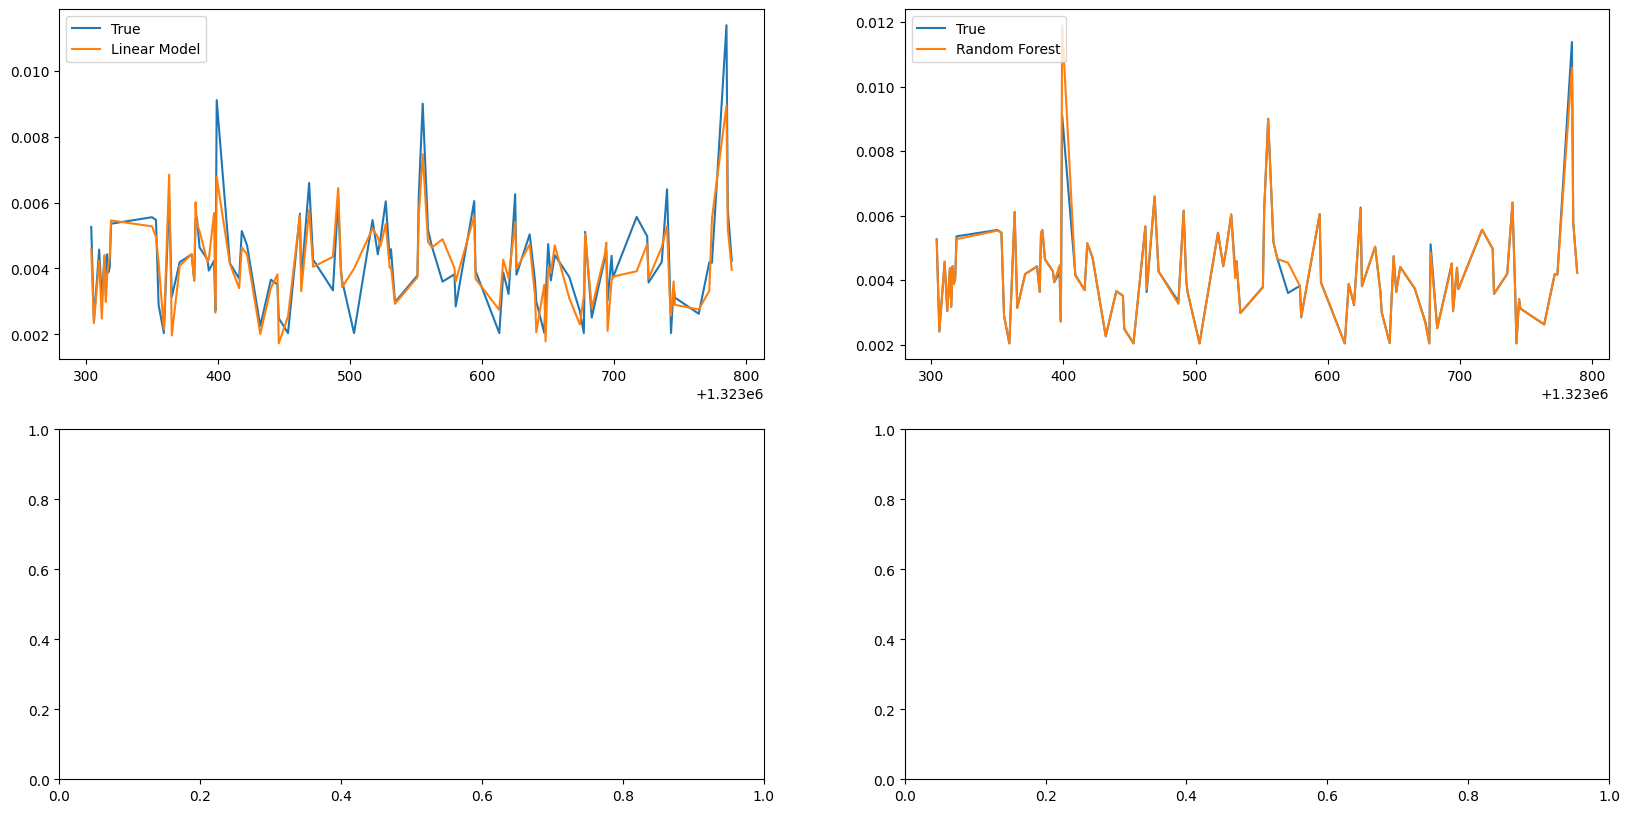

In [28]:
fig, axs = plt.subplots(2, 2, figsize=(20,10))
axs = axs.flatten()

for i, ax in zip(models_names, axs):
    ax.plot(test_df['consum_energia_final'][-100:], label='True')
    ax.plot(test_df[i][-100:], label=i)
    ax.legend(loc='upper left')

In [ ]:
# catalonia_analysis_df['consum_energia_final']

### 4. Tuning

Tuning starts here